---
# Social Network Analysis [CT0540]
---
**Project:** An Insight into Twitter Networks of Central Banks.

**Author:** [`André Ramolivaz`](https://www.linkedin.com/in/andreramolivaz/)

**Supervisor:** `Fabiana Zollo`

**Initial Analysis Structure:**
</br>
</br>

    CT0540
    ├── General overview
    │   ├── ✅ Presence Central Banks on social media
    │   ├── ✅ Our case study (analysis on BCE, BoE, FED)
    │   └── ❎ Networw analysis (networks graphs based on followers and tweet mentions, clustering type of user)
    ├── Tweet analysis (not only from official account)
    │   ├── ✅ Sentiment Analysis
    │   ├── ✅ Topic Modelin
    │   │   ├── ✅ ECB, BoE, FED
    │   │   └── ✅️ All
    │   ├── ✅ Hashtag analysis
    │   └── ✅ Engagement metrics
    └── Case study (whatever it takes)
        ├── ❎ Sentiment analysis 15 days before
        ├── ❎️ Sentiment analysis 15 days after
        ├── ❎ Main tweets
        └── ❎️ Correlation with stock market





In [1]:
import warnings
warnings.filterwarnings('ignore')
import csv
from tabulate import tabulate
import snscrape.modules.twitter as tw
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import networkx as nx
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook"
import tweepy
import random
import numpy as np
from collections import Counter
from pychord import Chord
from networkx.algorithms.community import greedy_modularity_communities
import community.community_louvain
from textblob import TextBlob
from langdetect import detect
import re



***
 **General analysis about the presence of Central Banks on social media**


In [22]:
central_banks_followers = [["European Central Bank", 732300, 428574, 73100],
                           ["Federal Reserve", 1032459, 111032, 197000],
                           ["Bank of England", 392400, 238169, 29700],
                           ["Bank of Canada", 226000, 128079, 11500],
                           ["Reserve Bank of Australia", 64900, 120415, 7610],
                           ["Banque de France ", 51000, 181391, 20000],
                           ["Banca d'Italia", 20900, 109047, 12500],
                           ["Banco de Mexico", 913500, 46631, 43000],
                           ["Reserve Bank of India", 1900000, 23050, 166000],
                           ["Central Bank of the Republic of Turkey", 39600, 56228, 13000],
                           ["Central Bank of Argentina", 153300, 129428, 10200],
                           ["Central Bank of Brazil", 454600, 417269, 114000],
                           ["Monetary Authority of Singapore", 25400, 119347, 2620],
                           ["Reserve Bank of New Zealand", 13900, 32917, 5120],
                           ["South African Reserve Bank", 112100, 159563, 2610],]

df = pd.DataFrame(central_banks_followers, columns=["Bank", "Twitter", "LinkedIn", "YouTube"])
print(tabulate(df, headers = ["Central Bank", "Twitter", "Linkedin", "Youtube", "Instagram"], tablefmt='fancy_grid', showindex="never"))

╒════════════════════════════════════════╤═══════════╤════════════╤═══════════╕
│ Central Bank                           │   Twitter │   Linkedin │   Youtube │
╞════════════════════════════════════════╪═══════════╪════════════╪═══════════╡
│ European Central Bank                  │    732300 │     428574 │     73100 │
├────────────────────────────────────────┼───────────┼────────────┼───────────┤
│ Federal Reserve                        │   1032459 │     111032 │    197000 │
├────────────────────────────────────────┼───────────┼────────────┼───────────┤
│ Bank of England                        │    392400 │     238169 │     29700 │
├────────────────────────────────────────┼───────────┼────────────┼───────────┤
│ Bank of Canada                         │    226000 │     128079 │     11500 │
├────────────────────────────────────────┼───────────┼────────────┼───────────┤
│ Reserve Bank of Australia              │     64900 │     120415 │      7610 │
├───────────────────────────────────────

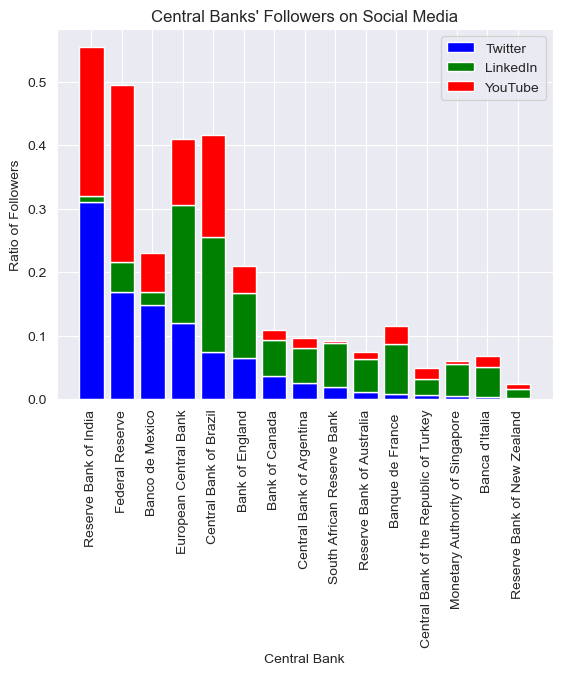

In [24]:
df["Twitter Ratio"] = df["Twitter"] / df["Twitter"].sum()
df["LinkedIn Ratio"] = df["LinkedIn"] / df["LinkedIn"].sum()
df["YouTube Ratio"] = df["YouTube"] / df["YouTube"].sum()

df.sort_values(by="Twitter Ratio", ascending=False, inplace=True)

fig, ax = plt.subplots()
ax.bar(df["Bank"], df["Twitter Ratio"], color="blue")
ax.bar(df["Bank"], df["LinkedIn Ratio"], color="green", bottom=df["Twitter Ratio"])
ax.bar(df["Bank"], df["YouTube Ratio"], color="red", bottom=df["Twitter Ratio"] + df["LinkedIn Ratio"])

ax.set_xlabel("Central Bank")
ax.set_ylabel("Ratio of Followers")
ax.set_title("Central Banks' Followers on Social Media")
plt.xticks(rotation=90)
ax.legend(labels=["Twitter", "LinkedIn", "YouTube"], loc="upper right")

plt.show()

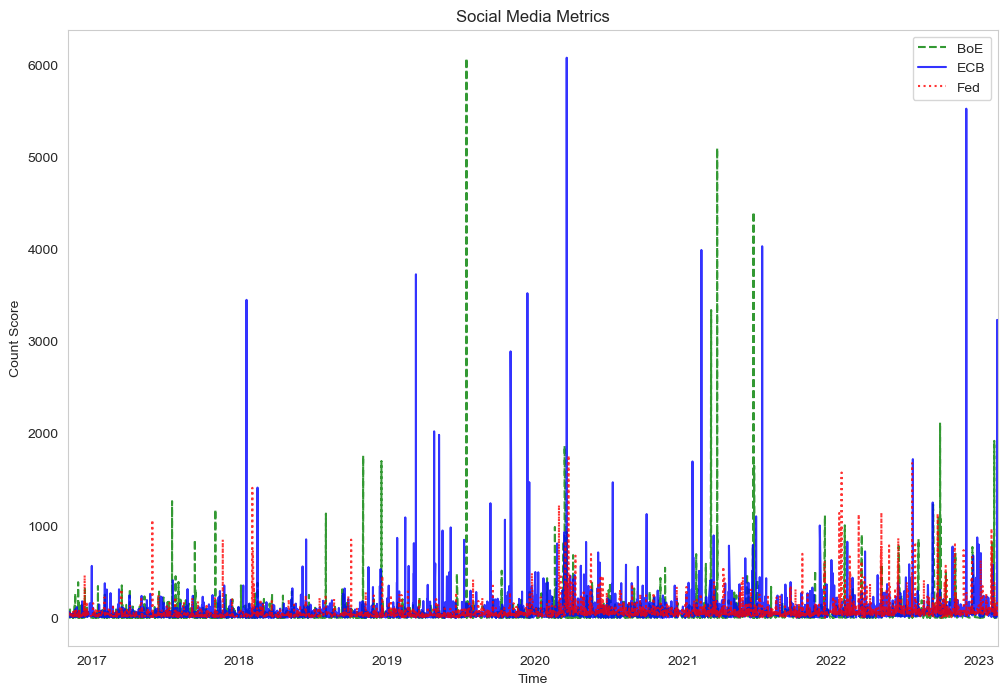

In [521]:
ecb_tweets = pd.read_csv('ecb_tweets.csv')
boe_tweets = pd.read_csv('bankofengland_tweets.csv')
fed_tweets = pd.read_csv('federalreserve_tweets.csv')

all_tweets = pd.concat([ecb_tweets, boe_tweets, fed_tweets])

all_tweets['tweet_date'] = pd.to_datetime(all_tweets['tweet_date'])

like_weight = 1
retweet_weight = 1.5

# Define a function to calculate the score using the weighted sum formula
def calculate_score(row):
    return (like_weight * row['like_count']) + (retweet_weight * row['retweet_count'])

# Apply the function to create a new column with the score
all_tweets['count_score'] = all_tweets.apply(calculate_score, axis=1)

plt.figure(figsize=(12, 8))
plt.title('Social Media Metrics')
plt.xlabel('Time')
plt.ylabel('Count Score')
plt.grid()

# Plot the data for each bank
for name, group in all_tweets.groupby('username'):
    if name == 'ecb':
        plt.plot(group['tweet_date'], group['count_score'], color='blue', linestyle='-', alpha=0.8, label='ECB')
    elif name == 'bankofengland':
        plt.plot(group['tweet_date'], group['count_score'], color='green', linestyle='--', alpha=0.8, label='BoE')
    elif name == 'federalreserve':
        plt.plot(group['tweet_date'], group['count_score'], color='red', linestyle=':', alpha=0.8, label='Fed')

# Set the X-axis limits to the earliest and latest dates in the dataset
plt.xlim(all_tweets['tweet_date'].min(), all_tweets['tweet_date'].max())

plt.legend()
plt.show()

***
**Collecting followers from ECB, BoE, FED for friends connection**

In [43]:
api_key = "ScV72nngWg1H0EOx0feRqbwCA"
api_key_secret = "SDe4LbAKTAAi7SRcmIX37irQr8aubWMRu7eLb0U1fVSIKaCWDK"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAOQ6VwEAAAAAtGKOf6bobogb5JEWiF6bmLmLkuA%3D5R9TCklAx9It9mBq87sXiieuBn9GzpexGmKBXviw8enl88AzYR"
access_token = "750009430540943360-70xlf5Ryr7zfC03Z5PA4BgWQ3jh4umU"
access_token_secret = "dOKhLbCEG0NawHIFT8SpInQwpd4DuZrpkwpKDVvmtYLL2"

In [67]:
def get_followers_csv(username, filename):

    # Authenticate the Twitter API with your API credentials
    auth = tweepy.OAuthHandler(api_key, api_key_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Get the follower IDs of the specified Twitter username
    follower_ids = api.get_follower_ids(screen_name=username)

    # Randomly select 1,000 follower IDs
    if (username == "ecb"):
        random_ids = random.sample(follower_ids, 732)
    if (username == "bankofengland"):
        random_ids = random.sample(follower_ids, 392)
    if (username == "federalreserve"):
        random_ids = random.sample(follower_ids, 1032)

    # Lookup the corresponding followers of the selected IDs
    followers = []
    for follower_id in random_ids:
        follower = api.get_user(user_id=follower_id)
        followers.append([follower.screen_name, follower.name])

    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Username', 'Name'])
        writer.writerows(followers)

    print(f'{len(followers)} followers saved to {filename}')

In [66]:
get_followers_csv('ecb', 'ecb_followers.csv')

732 followers saved to ecb_followers.csv


In [68]:
get_followers_csv('federalreserve', 'federalreserve_followers.csv')

Rate limit reached. Sleeping for: 648


1032 followers saved to federalreserve_followers.csv


In [69]:
get_followers_csv('bankofengland', 'bankofengland_followers.csv')

392 followers saved to bankofengland_followers.csv


***
**Collecting tweets from ECB, BoE, FED**

In [10]:
def get_tweets_csv(username, event_date, days_before, days_after, general):

    event_timestamp = time.mktime(time.strptime(event_date, "%Y-%m-%d"))
    start_timestamp = event_timestamp - (days_before * 24 * 60 * 60)
    end_timestamp = event_timestamp + (days_after * 24 * 60 * 60)

    start_date = time.strftime("%Y-%m-%d", time.gmtime(start_timestamp))
    end_date = time.strftime("%Y-%m-%d", time.gmtime(end_timestamp))

    if(general == 0):
        filename = username+"_tweets.csv"
    if(general == 1):
        filename = username+"_gnrl_tweets.csv"
    if(general == 2):
        filename = "15_days_before.csv"
    if(general == 3):
        filename = "15_days_after.csv"


    with open(filename, "w", encoding="utf-8", newline="") as f:

        writer = csv.writer(f)
        writer.writerow(["conversation_id","username", "tweet_text", "tweet_date", "retweet_count", "like_count", "view_count", "cash_tags", "hashtags", "mentionned_users", "quoted_tweet", "place", "vibe", "card"])

        if(username == "ecb" and general == 1):
            query = f"( from:{username} OR #ecb OR #europeancentralbank) since:{start_date} until:{end_date}"

        if(username == "ecb" and general == 0):
            query = f" from:{username} ) since:{start_date} until:{end_date}"

        if(username == "bankofengland" and general == 1):
            query = f"(from:{username} OR #boe OR #bankofengland) since:{start_date} until:{end_date}"

        if(username == "bankofengland" and general == 0):
            query = f"from:{username} since:{start_date} until:{end_date}"

        if(username == "federalreserve"and general == 1):
            query = f"(from:{username} OR #fed OR #federalreserve) since:{start_date} until:{end_date}"

        if(username == "federalreserve"and general == 0):
            query = f"from:{username} since:{start_date} until:{end_date}"

        if(general > 1):
            query = f"(#ecb OR #europeancentralbank OR #draghi OR #bce OR (#whateverittakes AND #ecb) since:{start_date} until:{end_date}"


        tweets = tw.TwitterSearchScraper(query=query).get_items()

        for tweet in tweets:

            writer.writerow([tweet.conversationId, tweet.username, tweet.content, tweet.date, tweet.retweetCount, tweet.likeCount, tweet.viewCount, tweet.cashtags, tweet.hashtags,tweet.mentionedUsers, tweet.quotedTweet, tweet.place, tweet.vibe, tweet.card])

From official account:

In [20]:
get_tweets_csv("ecb","2020-01-01",1152,1152,0)

In [21]:
get_tweets_csv("bankofengland","2020-01-01",1152,1152,0)

In [22]:
get_tweets_csv("federalreserve","2020-01-01",1152,1152,0)

From official account and related hashtag

In [26]:
get_tweets_csv("ecb","2022-01-01",182,182,1)

In [27]:
get_tweets_csv("bankofengland","2022-01-01",182,182,1)

In [ ]:
get_tweets_csv("federalreserve","2022-01-01",182,182,1)

***
**Tweets analysis**

In [15]:
def sentiment_analysis (username, general):

    if (general == 0):
        df = pd.read_csv(username+"_tweets.csv")
    else:
        df = pd.read_csv(username+"_gnrl_tweets.csv")

    df["tweet_text"] = df["tweet_text"].str.lower()

    stop_words = set(stopwords.words("english"))
    df["tweet_text"] = df["tweet_text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

    lemmatizer = WordNetLemmatizer()
    df["tweet_text"] = df["tweet_text"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    # create custom sentiment dictionaries for finance, economics, and banking
    finance_pos = ["profit", "gains", "growth", "success", "advantage", "benefit", "wealth", "prosperity"]
    finance_neg = ["loss", "decline", "failure", "disadvantage", "risk", "debt", "recession", "deficit"]
    economics_pos = ["development", "progress", "prosperity", "investment", "stability", "boom"]
    economics_neg = ["decline", "recession", "unemployment", "poverty", "debt", "inflation"]
    banking_pos = ["savings", "interest", "loan", "credit", "debit", "bank", "finance"]
    banking_neg = ["fraud", "scam", "bankruptcy", "default", "penalty", "overdraft", "fee"]

    sia = SentimentIntensityAnalyzer()

    def get_sentiment_scores(text):
        scores = sia.polarity_scores(text)
        for word in text.split():
            if word in finance_pos:
                scores["pos"] += 0.2
            elif word in finance_neg:
                scores["neg"] += 0.2
            elif word in economics_pos:
                scores["pos"] += 0.1
            elif word in economics_neg:
                scores["neg"] += 0.1
            elif word in banking_pos:
                scores["pos"] += 0.3
            elif word in banking_neg:
                scores["neg"] += 0.3
        return scores

    df[["sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"]] = df["tweet_text"].apply(get_sentiment_scores).apply(pd.Series)

    def get_sentiment_label(compound_score):
        if compound_score > 0.05:
            return "positive"
        elif compound_score < -0.05:
            return "negative"
        else:
            return "neutral"

    df["sentiment_label"] = df["sentiment_compound"].apply(get_sentiment_label)
    if (general == 0):
        fig, ax = plt.subplots(figsize=(8,6))
        sns.histplot(df, x="sentiment_compound", hue="sentiment_label", kde=True, ax=ax, bins=50)
        plt.title("Distribution of Sentiment Scores")
        plt.xlabel("Sentiment Compound Score")
        plt.ylabel("Count")
        plt.show()


        df["tweet_date"] = pd.to_datetime(df["tweet_date"])

        fig, ax = plt.subplots(figsize=(8,6))
        sns.scatterplot(data=df, x="tweet_date", y="sentiment_compound", hue="sentiment_label", ax=ax)
        plt.title("Sentiment Scores Over Time")
        plt.xlabel("Date")
        plt.ylabel("Sentiment Compound Score")
        plt.show()


    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

    emotion_freq = {}
    for emotion in emotions:
        emotion_freq[emotion] = df["tweet_text"].apply(lambda x: emotion in x).sum()

    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=list(emotion_freq.values()), y=list(emotion_freq.keys()), ax=ax, color="b")
    plt.title("Frequency of Emotions in Tweets")
    plt.xlabel("Frequency")
    plt.ylabel("Emotion")
    plt.show()

In [19]:
def topic_modeling_all ():
    df = pd.read_csv("ecb_tweets.csv")

    # Preprocess the tweet text
    stop_words = set(stopwords.words('english'))
    def preprocess_text(text):
        # Convert to lowercase
        text = text.lower()
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # Remove punctuation
        tokens = [token for token in tokens if token.isalpha()]
        return tokens

    # Tokenize and preprocess the tweet text
    df['tokens'] = df['tweet_text'].apply(preprocess_text)

    # Create a dictionary of all the tokens
    dictionary = corpora.Dictionary(df['tokens'])

    # Filter out low-frequency and high-frequency words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a corpus of bag-of-words for each tweet
    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    # Build a Latent Dirichlet Allocation (LDA) model with 10 topics
    lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)


    df = pd.read_csv("ecb_tweets.csv")

    stop_words = set(stopwords.words('english'))


    # Tokenize and preprocess the tweet text
    df['tokens'] = df['tweet_text'].apply(preprocess_text)

    # Create a dictionary of all the tokens
    dictionary = corpora.Dictionary(df['tokens'])

    # Filter out low-frequency and high-frequency words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a corpus of bag-of-words for each tweet
    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    # Build a Latent Dirichlet Allocation (LDA) model with 10 topics
    lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

    df = pd.read_csv("ecb_tweets.csv")

    # Preprocess the tweet text
    stop_words = set(stopwords.words('english'))


    # Tokenize and preprocess the tweet text
    df['tokens'] = df['tweet_text'].apply(preprocess_text)

    # Create a dictionary of all the tokens
    dictionary = corpora.Dictionary(df['tokens'])

    # Filter out low-frequency and high-frequency words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a corpus of bag-of-words for each tweet
    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    # Build a Latent Dirichlet Allocation (LDA) model with 10 topics
    lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

    G = nx.Graph()
    lda_models = [lda_model1, lda_model2, lda_model3]


    banks = ["ECB", "FED", "BoE"]
    # Add the nodes and edges from all LDA models
    for m, lda_model in enumerate(lda_models):
        for i, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
            topic_label = f"{banks[m]}T{i}"
            G.add_node(topic_label, size=500, color='red')
            for word, weight in topic:
                word_label = word
                G.add_node(word_label, size=weight*500, color='blue')
                G.add_edge(topic_label, word_label, weight=weight)

    # Define node position using a Fruchterman-Reingold layout
    pos = nx.layout.fruchterman_reingold_layout(G)

    # Convert the network graph to a pandas dataframe
    df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'weight'])
    df['weight'] = df['weight'].map(lambda x: x['weight'])

    # Add edges to the graph from the dataframe
    for index, row in df.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])

    # Compute the communities using the Louvain algorithm
    partition = community.community_louvain.best_partition(G)
    communities = [[] for _ in range(max(partition.values()) + 1)]
    for node, community_id in partition.items():
        communities[community_id].append(node)

    color_map = []
    size_map = []
    for node in G.nodes():
        if node.startswith('M'):
            color_map.append('red')
            size_map.append(500)
        else:
            community_id = partition[node]
            color = plt.cm.Set2(np.mod(community_id, 8) / 8.)
            color_map.append(color)
            size_map.append(200)

    # Define edge width based on the weight
    width_map = [d['weight']*10 for (u,v,d) in G.edges(data=True)]

    # Define the positions of the nodes using the spring layout algorithm
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    # Detect communities in the graph using the Louvain algorithm
    partition = community.community_louvain.best_partition(G)

    color_map = [partition.get(node) for node in G.nodes()]

    # Define node size based on whether it's a topic or a word
    size_map = [500 if n.startswith('S') else 200 for n in G.nodes()]

    # Define edge width based on the weight
    width_map = [d['weight']*10 for (u,v,d) in G.edges(data=True)]

    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map )
    nx.draw_networkx_edges(G, pos, width=width_map, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

    plt.axis('off')
    plt.title('Topic Modeling Network Graph')

    plt.show()


    print ("Some statistics:")
    print (nx.info(G))
    print (nx.number_of_nodes(G))
    print (nx.density(G))
    print (nx.is_connected(G))
    print (nx.average_shortest_path_length(G))





        # Compute the communities using the Louvain algorithm
    partition = community.community_louvain.best_partition(G)
    communities = [[] for _ in range(max(partition.values()) + 1)]
    for node, community_id in partition.items():
        communities[community_id].append(node)

    # Create a matrix of edge weights between communities
    n = len(communities)
    matrix = np.zeros((n, n))
    for u, v, data in G.edges(data=True):
        weight = data['weight']
        i = partition[u]
        j = partition[v]
        matrix[i, j] += weight
        matrix[j, i] += weight

    # Plot the chord diagram
    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(matrix, cmap=plt.cm.Blues)

    ticks = np.arange(n)
    ax.set_xticks(ticks)
    ax.set_xticklabels(communities, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(communities)

    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color="white")

    plt.show()

In [524]:
def topic_modeling_3D (username):
    df = pd.read_csv(username+"_tweets.csv")

    # Preprocess the tweet text
    stop_words = set(stopwords.words('english'))
    def preprocess_text(text):
        # Convert to lowercase
        text = text.lower()
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # Remove punctuation
        tokens = [token for token in tokens if token.isalpha()]
        return tokens

    # Tokenize and preprocess the tweet text
    df['tokens'] = df['tweet_text'].apply(preprocess_text)

    # Create a dictionary of all the tokens
    dictionary = corpora.Dictionary(df['tokens'])

    # Filter out low-frequency and high-frequency words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a corpus of bag-of-words for each tweet
    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    # Build a Latent Dirichlet Allocation (LDA) model with 10 topics
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

    topic_results = pd.DataFrame()
    # Create a network graph of topics and their top words
    G = nx.Graph()
    for i, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
        topic_label = "Topic " + str(i)
        G.add_node(topic_label, size=500, color='red')
        for word, weight in topic:
            word_label = word
            G.add_node(word_label, size=weight*500, color='blue')
            G.add_edge(topic_label, word_label, weight=weight)

    # Define the node positions using a Fruchterman-Reingold layout
    pos = nx.layout.fruchterman_reingold_layout(G)

    # Convert the network graph to a pandas dataframe
    df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'weight'])
    df['weight'] = df['weight'].map(lambda x: x['weight'])

    # Create a 3D visualization using plotly
    edge_trace = go.Scatter3d(x=[], y=[], z=[], mode='lines', line=dict(color='#888', width=3))
    node_trace = go.Scatter3d(x=[], y=[], z=[], mode='markers', marker=dict(symbol='circle', size=10, color=[], colorscale='Viridis', line=dict(color='rgb(50,50,50)', width=0.5), opacity=0.8))

    for edge in G.edges():
        x0, y0 = list(pos[edge[0]])
        x1, y1 = list(pos[edge[1]])
        z0, z1 = 0, 0  # Set z positions to 0
        edge_trace['x'] = list(edge_trace['x']) + [x0, x1, None]
        edge_trace['y'] = list(edge_trace['y']) + [y0, y1, None]
        edge_trace['z'] = list(edge_trace['z']) + [z0, z1, None]

    for node in G.nodes():
        x, y = pos[node]
        z = 0  # Set z position to 0
        node_trace['x'] = list(node_trace['x']) + [x]
        node_trace['y'] = list(node_trace['y']) + [y]
        node_trace['z'] = list(node_trace['z']) + [z]
        node_trace['marker']['color'] = list(node_trace['marker']['color']) + [G.nodes[node]['size']]

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=username+' - network graphs topics',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        scene=dict(
                            xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                            yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                            zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                            camera=dict(up=dict(x=0, y=0, z=1), eye=dict(x=-1.5, y=1.5, z=1.5))
                        )
                    ))
    fig.show()

In [15]:
def topic_modeling2(username):
    df = pd.read_csv(username+"_tweets.csv")

    # Preprocess the tweet text
    stop_words = set(stopwords.words('english'))
    def preprocess_text(text):
        # Convert to lowercase
        text = text.lower()
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # Remove punctuation
        tokens = [token for token in tokens if token.isalpha()]
        return tokens

    # Tokenize and preprocess the tweet text
    df['tokens'] = df['tweet_text'].apply(preprocess_text)

    # Create a dictionary of all the tokens
    dictionary = corpora.Dictionary(df['tokens'])

    # Filter out low-frequency and high-frequency words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a corpus of bag-of-words for each tweet
    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]



    # Build a Latent Dirichlet Allocation (LDA) model with 10 topics
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)


    for i, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
        topic_label = "S" + str(i)
        print  ("Topic:" +topic_label)
        for word, weight in topic:
            print("Word: "+word + ", wheight:  "+ str(weight))

    # Create a network graph of topics and their top words
    G = nx.Graph()
    for i, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
        topic_label = "S" + str(i)
        G.add_node(topic_label, size=500, color='red')
        for word, weight in topic:
            word_label = word
            G.add_node(word_label, size=weight*500, color='blue')
            G.add_edge(topic_label, word_label, weight=weight)

    # Define the node positions using a Fruchterman-Reingold layout
    pos = nx.layout.fruchterman_reingold_layout(G)

    # Convert the network graph to a pandas dataframe
    df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'weight'])
    df['weight'] = df['weight'].map(lambda x: x['weight'])

     # Create an empty graph
    G = nx.Graph()

    # Add edges to the graph from the dataframe
    for index, row in df.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])

    color_map = ['#1f77b4' if n.startswith('S') else '#ff7f0e' for n in G.nodes()]
    size_map = [300 if n.startswith('S') else 200 for n in G.nodes()]

    width_map = [d['weight']*10 for (u,v,d) in G.edges(data=True)]

    pos = nx.spring_layout(G, iterations=50)

    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map )
    nx.draw_networkx_edges(G, pos, width=width_map, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

    edge_labels = {(row['source'], row['target']): '{:.2f}'.format(row['weight']) for index, row in df.iterrows()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

    plt.axis('off')
    plt.title('Topic Modeling Network Graph')

    plt.show()

In [6]:
def hashtag_evaluation(username):
    df = pd.read_csv(username+'_gnrl_tweets.csv')

    # Replace NaN values in hashtags column with empty lists
    df['hashtags'].fillna('[]', inplace=True)

    # Create a new column for the total number of hashtags in each tweet
    df['hashtags_count'] = df['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)


    # Extract all unique hashtags from the dataset and store them in a list
    hashtags_list = []
    for hashtags in df['hashtags']:
        hashtags_list.extend(eval(hashtags))
    unique_hashtags = list(set(hashtags_list))
    if 'ecb' in unique_hashtags:
        unique_hashtags.remove('ecb')
    if 'europeancentralbank' in unique_hashtags:
        unique_hashtags.remove('europeancentralbank')
    if 'ECB' in unique_hashtags:
        unique_hashtags.remove('ECB')
    if 'fed' in unique_hashtags:
        unique_hashtags.remove('fed')
    if 'federalreserve' in unique_hashtags:
        unique_hashtags.remove('federalreserve')
    if 'FederalReserve' in unique_hashtags:
        unique_hashtags.remove('FederalReserve')
    if 'BankofEngland' in unique_hashtags:
        unique_hashtags.remove('BankofEngland')
    if 'FED' in unique_hashtags:
        unique_hashtags.remove('FED')
    if 'boe' in unique_hashtags:
        unique_hashtags.remove('boe')
    if 'BoE' in unique_hashtags:
        unique_hashtags.remove('BoE')
    if 'bankofengland' in unique_hashtags:
        unique_hashtags.remove('bankofengland')
    if 'Fed' in unique_hashtags:
        unique_hashtags.remove('Fed')
    if 'BOE' in unique_hashtags:
        unique_hashtags.remove('BOE')
    if 'BankOfEngland' in unique_hashtags:
        unique_hashtags.remove('BankOfEngland')
    if 'Bank0fEngland' in unique_hashtags:
        unique_hashtags.remove('BankofEngland')

    # Create a new dataframe to store the count of each hashtag in the entire dataset
    hashtag_counts = pd.DataFrame(columns=['hashtag', 'count'])
    for hashtag in unique_hashtags:
        count = hashtags_list.count(hashtag)
        hashtag_counts = hashtag_counts.append({'hashtag': hashtag, 'count': count}, ignore_index=True)

    # Create a bar chart to visualize the most popular hashtags in the dataset
    top_hashtags = hashtag_counts.sort_values('count', ascending=False).head(10)
    sns.barplot(x='hashtag', y='count', data=top_hashtags)
    plt.title('Top 10 Hashtags')
    plt.xticks(rotation=90)
    plt.show()

    # Calculate the frequency of each hashtag over time
    df['date'] = pd.to_datetime(df['tweet_date'])
    hashtag_freq = pd.DataFrame(columns=['date'] + unique_hashtags)
    for date, group in df.groupby(df['date'].dt.date):
        date_hashtags = []
        for hashtags in group['hashtags']:
            date_hashtags.extend(eval(hashtags))
        date_hashtags_count = Counter(date_hashtags)
        date_hashtags_count['date'] = date
        hashtag_freq = hashtag_freq.append(date_hashtags_count, ignore_index=True)

    # Create a line graph to visualize the trend of each hashtag over time
    hashtag_freq.set_index('date', inplace=True)
    hashtag_freq.plot(figsize=(12, 6))
    plt.title('Hashtag Frequency over Time')
    plt.legend().set_visible(False)
    plt.show()


    # Perform sentiment analysis on the tweets
    analyzer = SentimentIntensityAnalyzer()
    for hashtag in unique_hashtags:
        hashtag_df = df[df['hashtags'].str.contains(hashtag)]
        hashtag_df['sentiment'] = hashtag_df['tweet_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
        mean_sentiment = hashtag_df['sentiment'].mean()
        print('Hashtag:', hashtag)
        print('Mean Sentiment:', mean_sentiment)

    # Create a scatter plot to visualize the relationship between hashtag frequency and sentiment score
    hashtag_sentiment = pd.DataFrame(columns=['hashtag', 'frequency', 'sentiment'])
    for hashtag in unique_hashtags:
        hashtag_df = df[df['hashtags'].str.contains(hashtag)]
        frequency = hashtag_df.shape[0]
        sentiment = hashtag_df['tweet_text'].apply(lambda x: analyzer.polarity_scores(x)['compound']).mean()
        hashtag_sentiment = hashtag_sentiment.append({'hashtag': hashtag, 'frequency': frequency, 'sentiment': sentiment}, ignore_index=True)

    sns.scatterplot(data=hashtag_sentiment, x='frequency', y='sentiment', hue='hashtag')
    plt.title('Hashtag Frequency vs. Sentiment')
    plt.legend().set_visible(False)
    plt.show()

In [527]:
def correlations1 ():


    tweets = pd.concat([ecb_tweets, boe_tweets, fed_tweets])

    # Drop the unnecessary columns
    tweets = tweets.drop(['conversation_id', 'cash_tags', 'quoted_tweet', 'vibe', 'card'], axis=1)

    # Add a column for hashtag count
    tweets['hashtag_count'] = tweets['hashtags'].str.count(',')+1

    # Load the sentiment scores for each tweet
    sentiment_scores = pd.read_csv('sentiment_scores.csv')

    # Merge the sentiment scores into the tweets DataFrame
    tweets = pd.merge(tweets, sentiment_scores, on='tweet_text')

    # Add a column for engagement ratio
    tweets['engagement_ratio'] = (tweets['retweet_count'] + tweets['like_count'] + tweets['view_count']) / tweets['like_count']

    # Compute the correlation matrix
    corr = tweets.corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, cmap='Blues', center=0, annot=True, fmt='.2f', ax=ax)
    ax.set_title('Correlation Plot of Twitter Data')
    plt.show()


In [528]:
from langdetect import detect, LangDetectException
def correlations2 ():
    # Define the detect_language function
    def detect_language(text):
        try:
            return detect(text)
        except LangDetectException:
            return 'unknown'


    tweets = pd.concat([ecb_tweets, boe_tweets, fed_tweets])

    tweets = tweets.drop(['conversation_id', 'cash_tags', 'quoted_tweet', 'vibe', 'card'], axis=1)

    tweets['hashtag_count'] = tweets['hashtags'].str.count('#')

    sentiment_scores = pd.read_csv('sentiment_scores.csv')

    tweets = pd.merge(tweets, sentiment_scores, on='tweet_text')

    tweets['engagement_ratio'] = (tweets['retweet_count'] + tweets['like_count'] + tweets['view_count']) / tweets['like_count']

    # Add columns for mentioned count, language, and username
    tweets['mentioned_count'] = tweets['mentionned_users'].str.count('@')
    tweets['language'] = tweets['tweet_text'].apply(lambda x: detect_language(x))
    tweets['username'] = tweets['username'].apply(lambda x: x.lower())

    # Visualize the distribution of mentioned count by sentiment score
    sns.boxplot(x='sentiment_score', y='mentioned_count', data=tweets)
    plt.title('Distribution of Mentioned Count by Sentiment Score')
    plt.show()

    # Create a bar chart of the top 10 most frequent languages
    top_languages = tweets['language'].value_counts().head(10)
    sns.barplot(x=top_languages.values, y=top_languages.index)
    plt.title('Top 10 Most Frequent Languages')
    plt.show()

In [529]:
def get_sentiment():
    ecb_tweets = pd.read_csv('ecb_gnrl_tweets.csv')
    boe_tweets = pd.read_csv('bankofengland_gnrl_tweets.csv')
    fed_tweets = pd.read_csv('federalreserve_gnrl_tweets.csv')

    tweets = pd.concat([ecb_tweets, boe_tweets, fed_tweets])

    # Define a function to compute sentiment scores
    def get_sentiments(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity

    # Apply the function to each tweet in the DataFrame
    tweets['sentiment_score'] = tweets['tweet_text'].apply(get_sentiments)

    # Save the sentiment scores to a csv file
    tweets[['tweet_text', 'sentiment_score']].to_csv('sentiment_scores.csv', index=False)

In [507]:
def data_gephi_followers (username):
    df = pd.read_csv(username+"_followers.csv")

    # Create the nodes DataFrame with the desired attributes
    nodes_df = pd.DataFrame({'username': df['Username'], 'language': 0, 'isInfluencer': 0, 'profession': 0, 'isBank': 0, 'hashtags': 0})





    # Create the edges DataFrame with the desired attributes
    edges_df = pd.DataFrame({'source': df['Username'], 'target': username, 'type': 'follow', 'weight': 1.5})

    # Save the nodes and edges DataFrames to CSV files
    nodes_df.to_csv(username+'_followers_nodes.csv', index=False)
    edges_df.to_csv(username+'_followers_edges.csv', index=False)

In [501]:
def data_gephi_tweet(username, general):

    import ast
    if (general == 0):
        df = pd.read_csv(username+"_tweets.csv")
    else:
        df = pd.read_csv(username+"_gnrl_tweets.csv")

    # Initialize empty lists to store nodes and edges
    nodes = []
    edges = []

    def classify_language(text):
        try:
            lang = detect(text)
        except:
            lang = "unknown"
        return lang

    # Define a function to classify user profession based on keywords in tweet text
    def classify_profession(text):
        keywords = {
            "politics": ["politics", "election", "vote", "government"],
            "analyst": ["analysis", "research", "report", "data"],
            "finance expert": ["finance", "economy", "market", "investment"],
            "supporter": ["support", "advocate", "promote", "help"],
            "critic": ["criticize", "oppose", "doubt", "question"],
            "curious": ["curious", "learn", "explore", "discover"],
            "conspiracy theorist": ["conspiracy", "hoax", "fake", "misinformation"]
        }
        for prof, words in keywords.items():
            for word in words:
                if word in text.lower():
                    return prof
        return "unknown"

    # Iterate through each row in the dataframe
    for i, row in df.iterrows():
        # Create a node for the user who made the tweet
        user = {
            "username": row["username"],
            "language": classify_language(row["tweet_text"]),
            "isInfluencer": 1 if row["like_count"] > 1000 else 0,
            "profession": classify_profession(row["tweet_text"]),
            "isBank": 0,
            "isViral": 1 if row["retweet_count"] + row["like_count"] + row["view_count"] > 10000 else 0,
            "hashtags": row["hashtags"]
        }
        if user not in nodes:
            nodes.append(user)

        mentionned_users = row["mentionned_users"]
        try:
            mentioned_users = re.findall("username='(.*?)'", mentionned_users)
        except  TypeError:
            mentioned_users = []



        for mention in mentioned_users:
            user = {"username": mention.strip(), "language": 0, "isInfluencer": 0, "profession": 0, "isBank": 0, "isViral": 0, "hashtags": 0}
            if user not in nodes:
                nodes.append(user)

        # Create an edge between the user who made the tweet and the Bank related
        edge = {"source": row["username"], "target": username, "type": "tweet", "weight": 1.0}
        if edge not in edges:
            edges.append(edge)

        # Create an edge for each user mentioned in the tweet
        for mention in mentioned_users:
            edge = {"source": row["username"], "target": mention.strip(), "type": "mention", "weight": 0.5}
            if edge not in edges:
                edges.append(edge)

    # Write nodes to CSV file
    df_nodes = pd.DataFrame(nodes)
    if(general == 0):
        df_nodes.to_csv(username+"_tweets_nodes.csv", index=False)
    else:
        df_nodes.to_csv(username+"_gnrl_tweets_nodes.csv", index=False)


    # Write edges to CSV file
    df_edges = pd.DataFrame(edges)
    if(general == 0):
        df_edges.to_csv(username+"_tweets_edges.csv", index=False)
    else:
        df_edges.to_csv(username+"_gnrl_tweets_edges.csv", index=False)

In [511]:
def final_gephi_data() :
    df0 = pd.read_csv("bankofengland_followers_edges.csv")
    df1 = pd.read_csv("bankofengland_gnrl_tweets_edges.csv")
    df2 = pd.read_csv("bankofengland_tweets_edges.csv")

    df3 = pd.read_csv("ecb_followers_edges.csv")
    df4 = pd.read_csv("ecb_gnrl_tweets_edges.csv")
    df5 = pd.read_csv("ecb_tweets_edges.csv")


    df6 = pd.read_csv("federalreserve_followers_edges.csv")
    df7 = pd.read_csv("federalreserve_gnrl_tweets_edges.csv")
    df8 = pd.read_csv("federalreserve_tweets_edges.csv")

    final_edges = [df0,df1,df2,df3,df4,df5,df6,df7,df8]

    final_edges_df = pd.concat(final_edges)

    final_edges_df.to_csv("final_edges.csv", index=False)

    df0 = pd.read_csv("bankofengland_followers_nodes.csv")
    df1 = pd.read_csv("bankofengland_gnrl_tweets_nodes.csv")
    df2 = pd.read_csv("bankofengland_tweets_nodes.csv")

    df3 = pd.read_csv("ecb_followers_nodes.csv")
    df4 = pd.read_csv("ecb_gnrl_tweets_nodes.csv")
    df5 = pd.read_csv("ecb_tweets_nodes.csv")


    df6 = pd.read_csv("federalreserve_followers_nodes.csv")
    df7 = pd.read_csv("federalreserve_gnrl_tweets_nodes.csv")
    df8 = pd.read_csv("federalreserve_tweets_nodes.csv")

    final_nodes = [df0,df1,df2,df3,df4,df5,df6,df7,df8]

    final_nodes_df = pd.concat(final_nodes)

    final_nodes_df = final_nodes_df.drop_duplicates(subset=["username"])

    final_nodes_df.to_csv("final_nodes.csv", index=False)

In [495]:
data_gephi_tweet("ecb", 0)
data_gephi_tweet("bankofengland", 0)
data_gephi_tweet("federalreserve", 0)

In [496]:
data_gephi_tweet("ecb", 1)
data_gephi_tweet("bankofengland", 1)
data_gephi_tweet("federalreserve", 1)

In [508]:
data_gephi_followers("ecb")
data_gephi_followers("bankofengland")
data_gephi_followers("federalreserve")

In [512]:
final_gephi_data()

Correlation data obtained

In [530]:
get_sentiment()

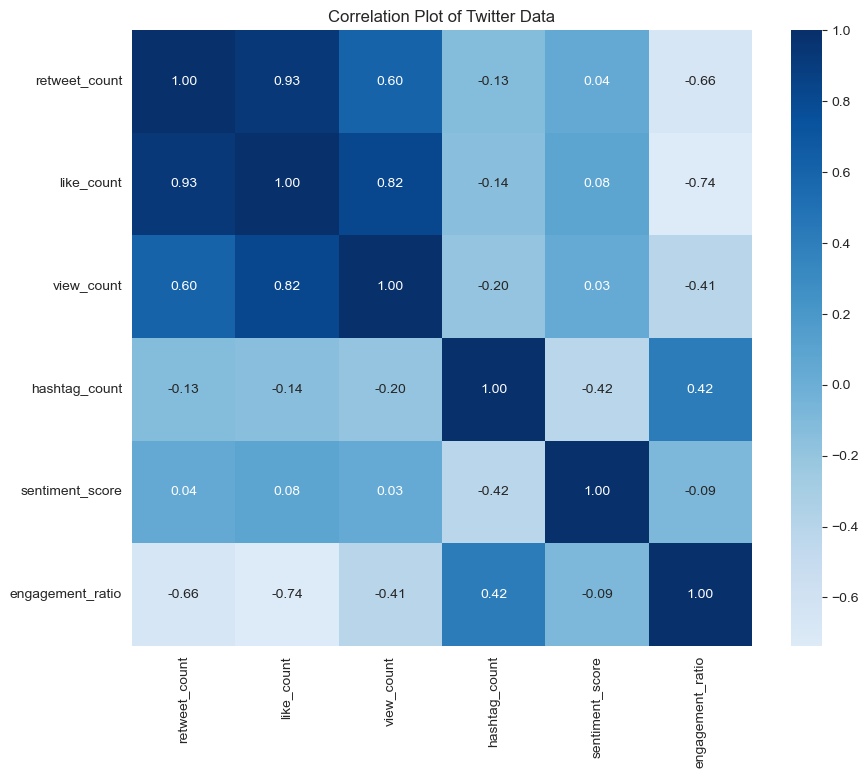

In [531]:
correlations1()

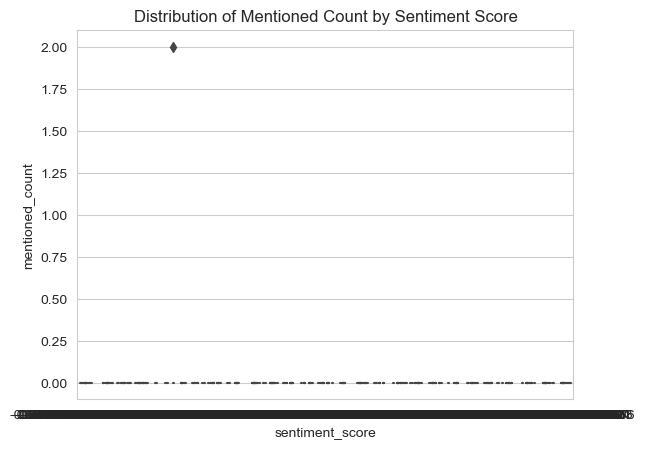

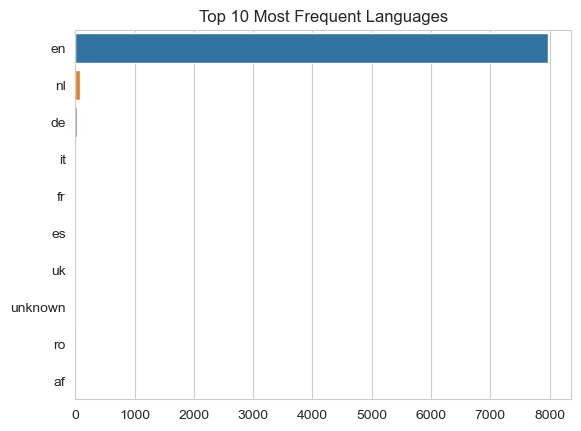

In [532]:
correlations2()

Sentiment Analysis - from official account

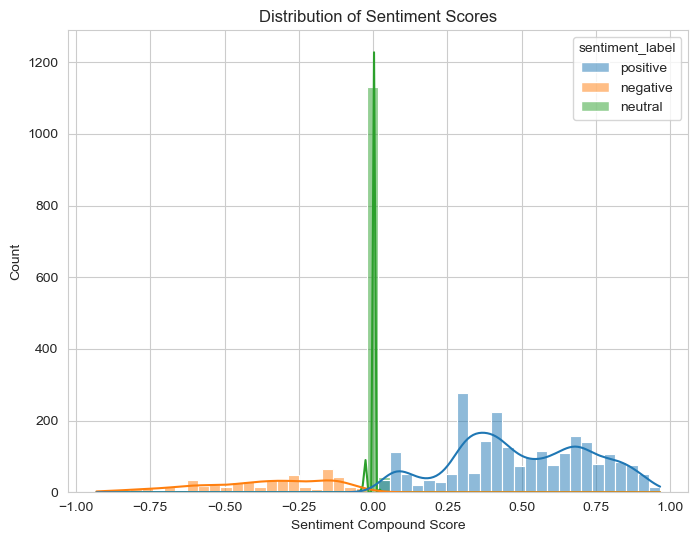

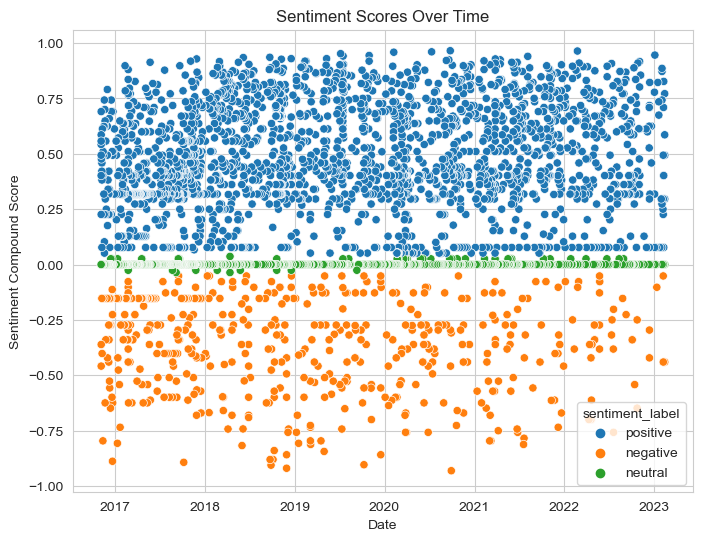

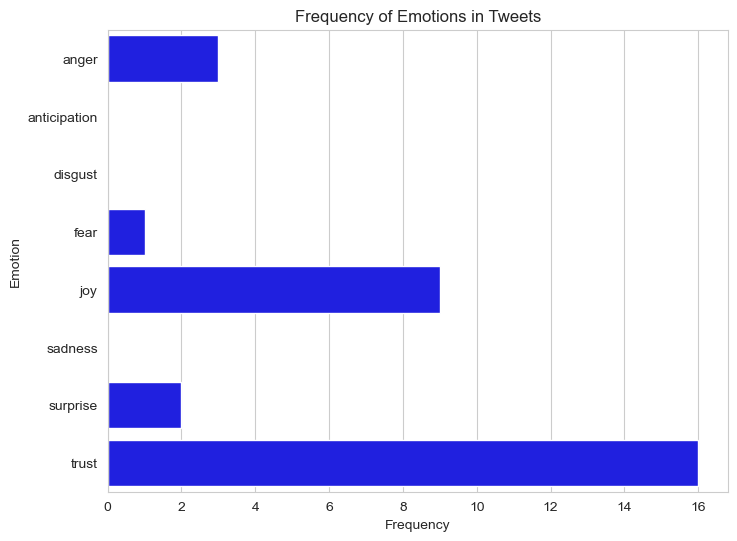

In [533]:
sentiment_analysis("bankofengland", 0)

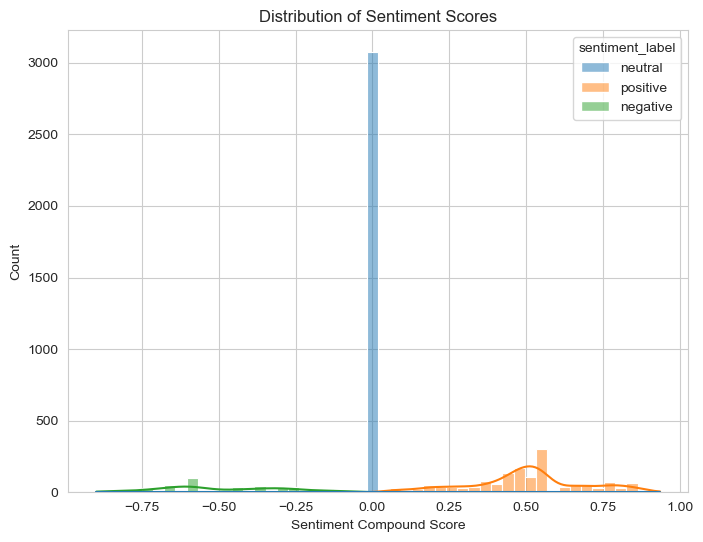

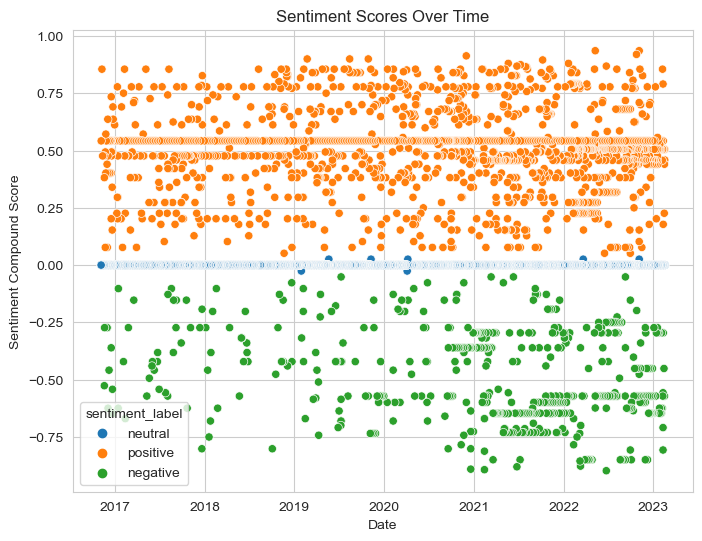

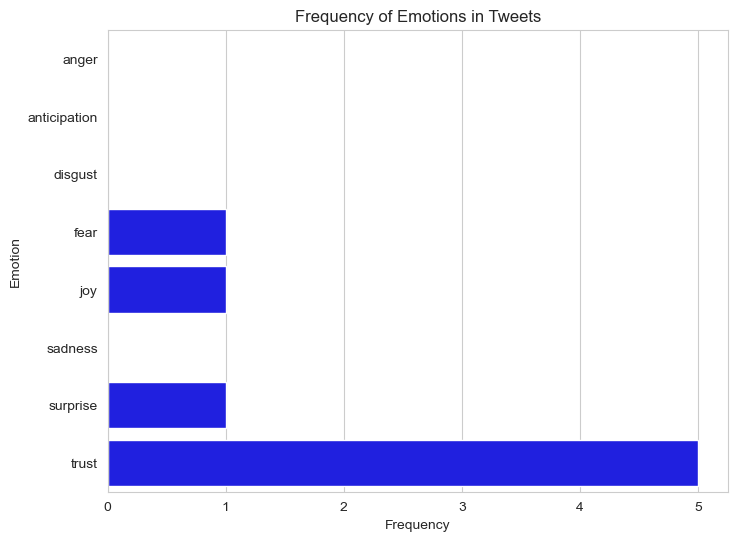

In [534]:
sentiment_analysis("federalreserve", 0)

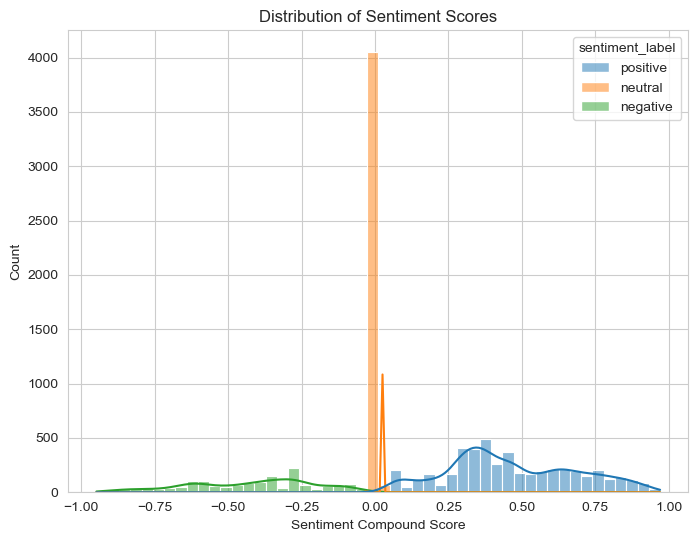

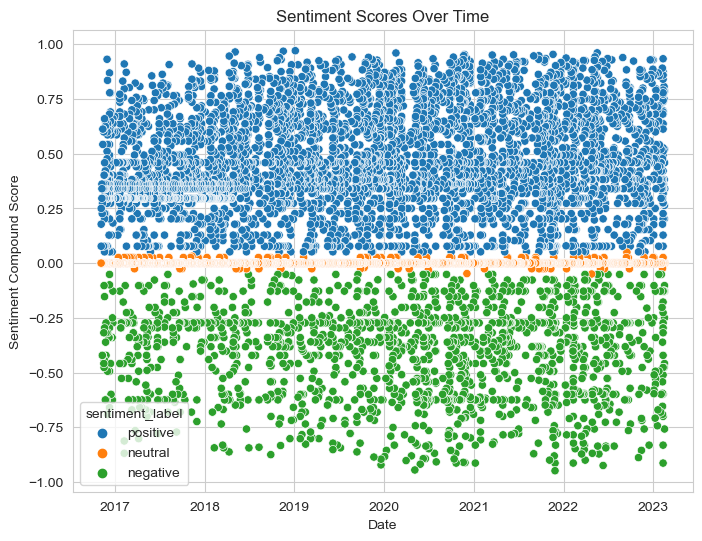

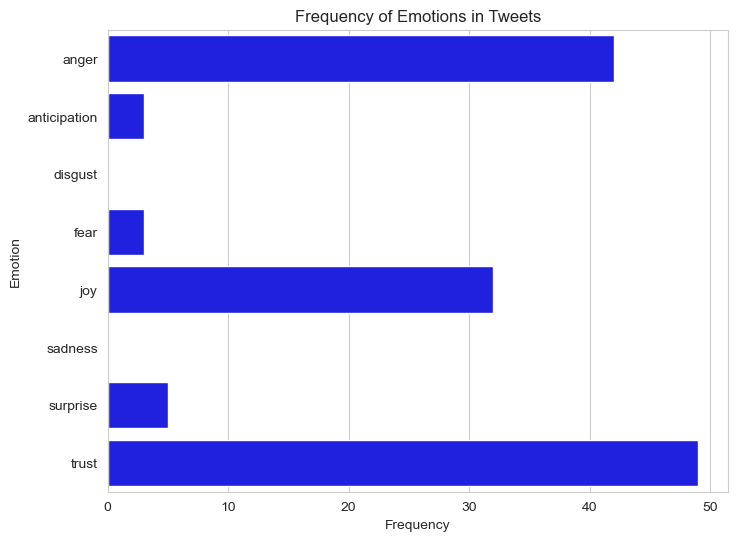

In [535]:
sentiment_analysis("ecb", 0)

Sentiment Analysis - from official account and related hashtag

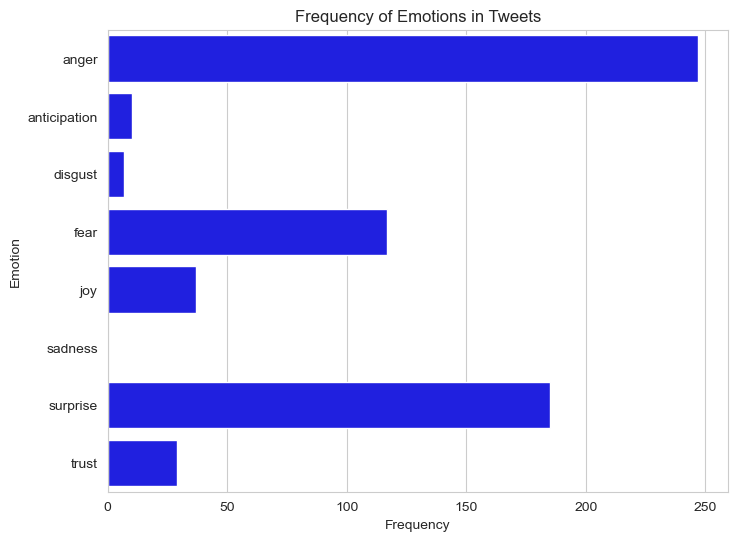

In [536]:
sentiment_analysis("bankofengland", 1)

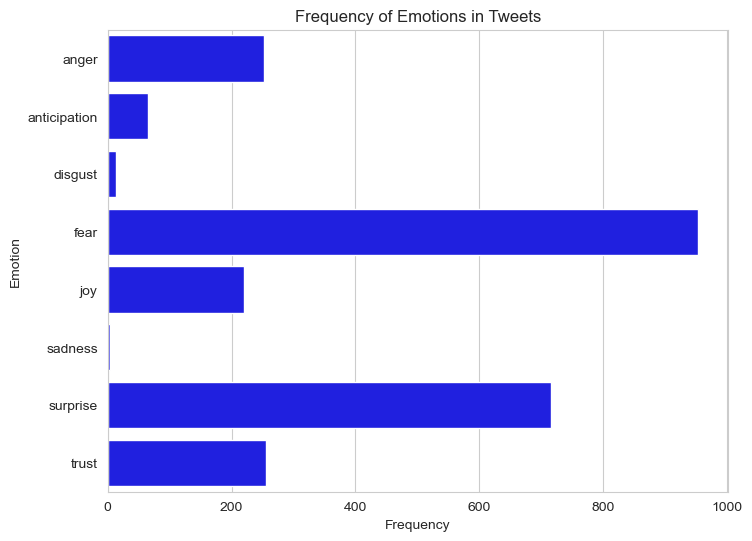

In [537]:
sentiment_analysis("federalreserve", 1)

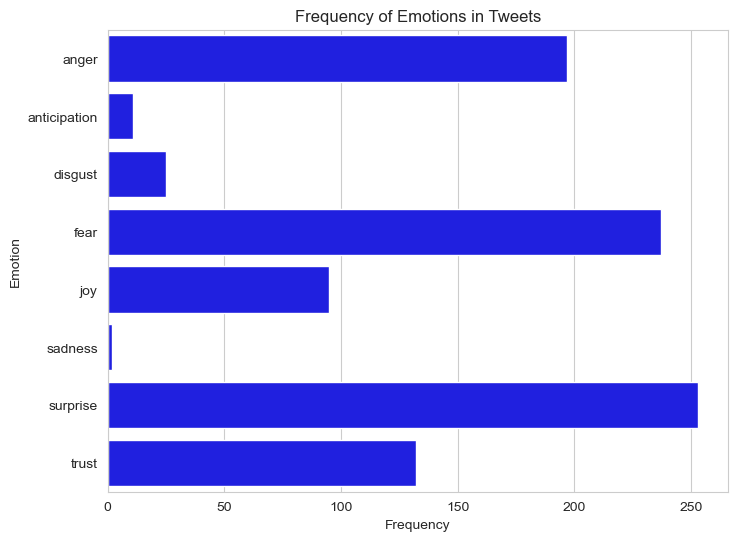

In [538]:
sentiment_analysis("ecb", 1)

Topic Modeling

Topic:S0
Word: purchased, wheight:  0.07801867
Word: cumulatively, wheight:  0.07583337
Word: settled, wheight:  0.07570415
Word: mln, wheight:  0.07518711
Word: job, wheight:  0.0459998
Word: management, wheight:  0.024704726
Word: securities, wheight:  0.023925688
Word: sector, wheight:  0.022695124
Word: assets, wheight:  0.022135546
Word: public, wheight:  0.021221805
Topic:S1
Word: financial, wheight:  0.018905103
Word: stability, wheight:  0.013748832
Word: reforms, wheight:  0.011127369
Word: measures, wheight:  0.010628144
Word: banks, wheight:  0.010577649
Word: structural, wheight:  0.010449903
Word: growth, wheight:  0.010319906
Word: fiscal, wheight:  0.010040799
Word: review, wheight:  0.009632226
Word: prices, wheight:  0.009286188
Topic:S2
Word: banking, wheight:  0.042091772
Word: speech, wheight:  0.031519253
Word: european, wheight:  0.030272122
Word: board, wheight:  0.02925684
Word: supervision, wheight:  0.029146047
Word: supervisory, wheight:  0.028012399
Word: ec

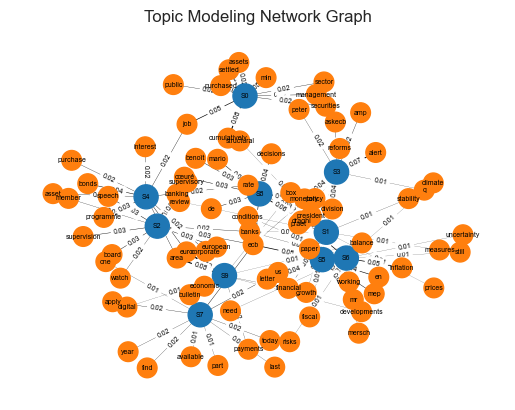

In [16]:
topic_modeling2("ecb")

Topic:S0
Word: policy, wheight:  0.0339775
Word: costs, wheight:  0.025331715
Word: monetary, wheight:  0.025223954
Word: experts, wheight:  0.025137324
Word: companies, wheight:  0.024931682
Word: affecting, wheight:  0.022981245
Word: underground, wheight:  0.021746919
Word: economy, wheight:  0.019779652
Word: futureforumboe, wheight:  0.015388368
Word: mpc, wheight:  0.015338809
Topic:S1
Word: full, wheight:  0.058870696
Word: us, wheight:  0.040221248
Word: boetechcomp, wheight:  0.03409424
Word: tech, wheight:  0.033751424
Word: competition, wheight:  0.02662706
Word: use, wheight:  0.023621375
Word: year, wheight:  0.022712804
Word: tell, wheight:  0.02245734
Word: days, wheight:  0.021640114
Word: would, wheight:  0.020456428
Topic:S2
Word: boeknowledgebank, wheight:  0.06178067
Word: find, wheight:  0.061585914
Word: financial, wheight:  0.045502868
Word: guide, wheight:  0.033676706
Word: careers, wheight:  0.027826672
Word: graduate, wheight:  0.027385546
Word: matter, wheig

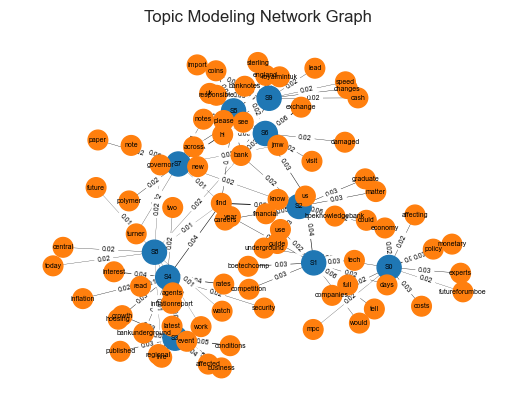

In [17]:
topic_modeling2("bankofengland")

Topic:S0
Word: chairman, wheight:  0.07757126
Word: money, wheight:  0.026542684
Word: learn, wheight:  0.026320133
Word: help, wheight:  0.023227712
Word: information, wheight:  0.021320289
Word: fed, wheight:  0.020644633
Word: personal, wheight:  0.01941747
Word: avoid, wheight:  0.018435897
Word: ones, wheight:  0.017888252
Word: loved, wheight:  0.017888248
Topic:S1
Word: report, wheight:  0.13766488
Word: feddata, wheight:  0.10901282
Word: guide, wheight:  0.10774101
Word: interactive, wheight:  0.10766365
Word: weekly, wheight:  0.1061689
Word: balancesheet, wheight:  0.10616885
Word: foreign, wheight:  0.014455213
Word: answers, wheight:  0.013392355
Word: small, wheight:  0.010197442
Word: liquidity, wheight:  0.009172783
Topic:S2
Word: credit, wheight:  0.14211577
Word: consumer, wheight:  0.06355366
Word: amp, wheight:  0.03968512
Word: revolving, wheight:  0.033900995
Word: nonrevolving, wheight:  0.03301011
Word: saar, wheight:  0.030907521
Word: financial, wheight:  0.02

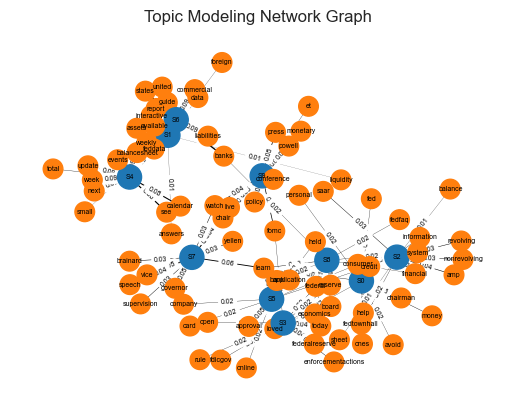

In [18]:
topic_modeling2("federalreserve")

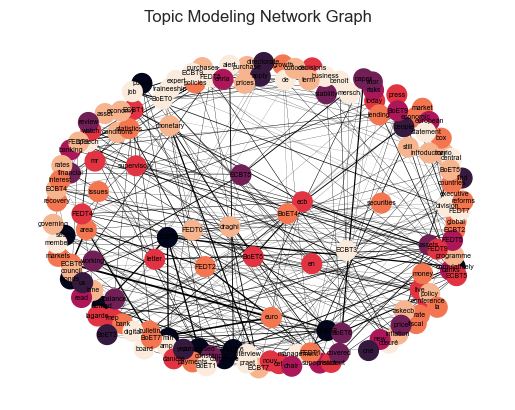

Some statistics:
Graph with 148 nodes and 300 edges
148
0.027578599007170437
True
3.926089354660783


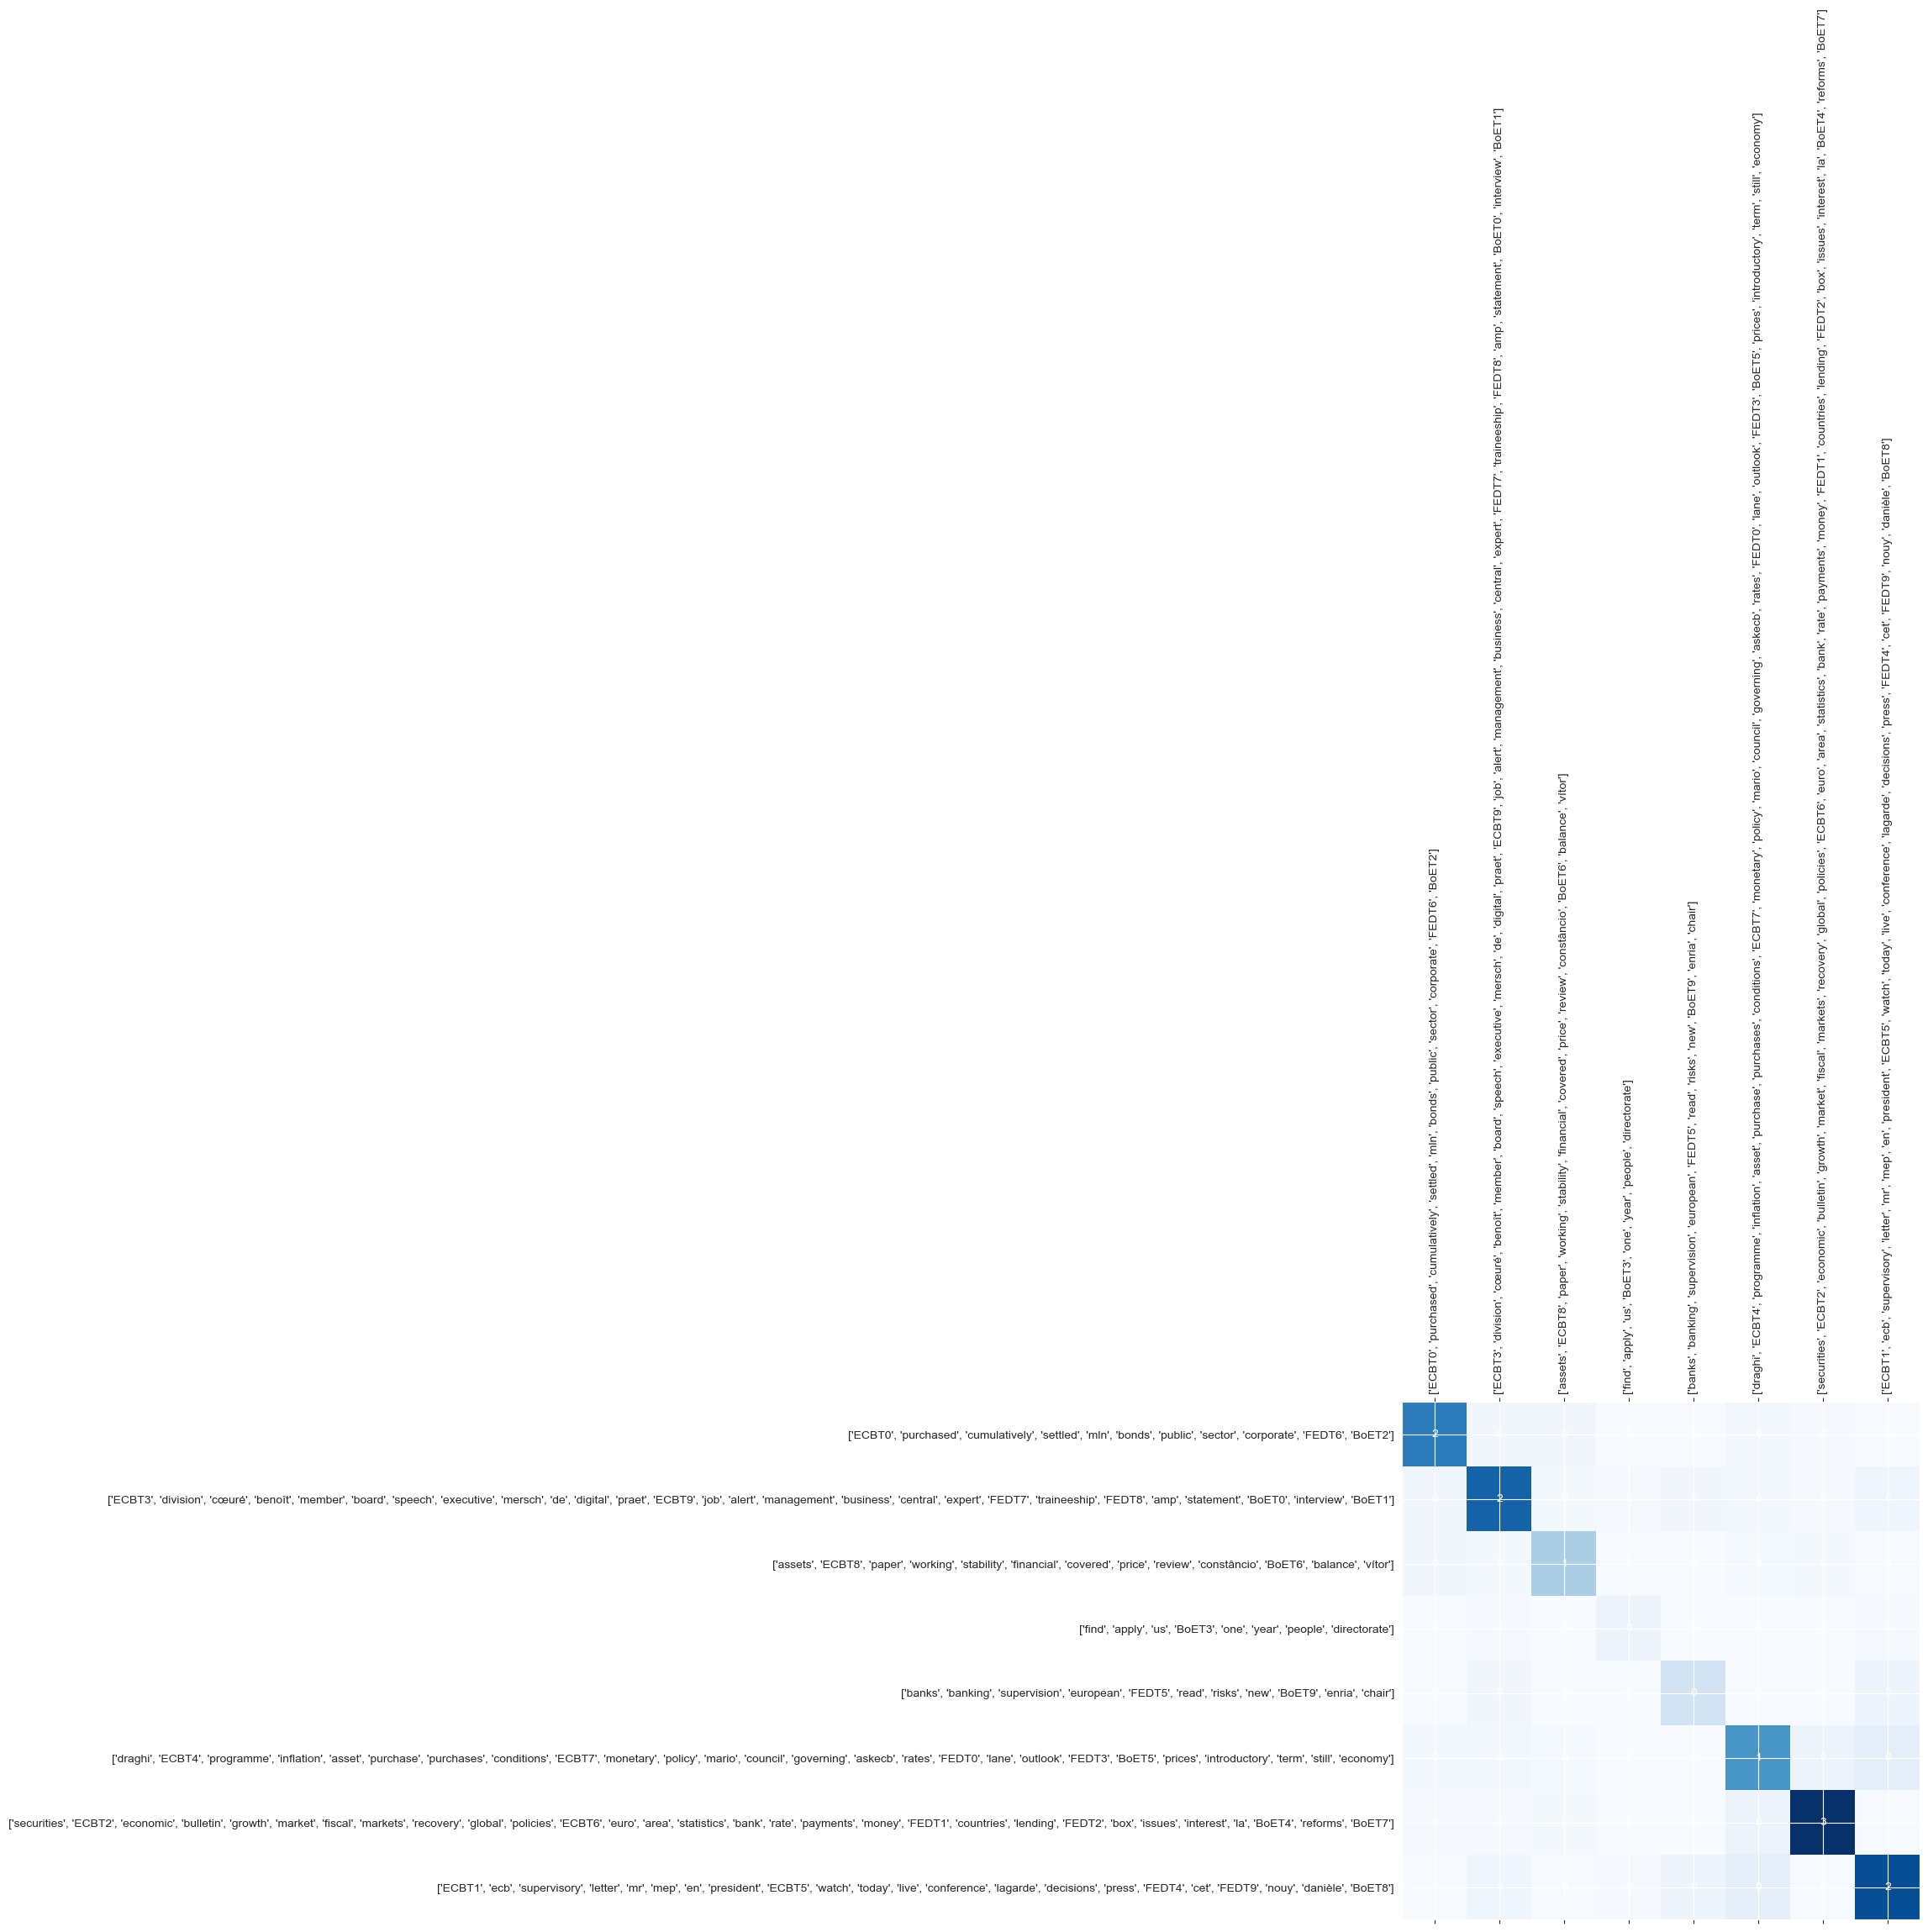

In [20]:
topic_modeling_all()

Hashtag Evaluation

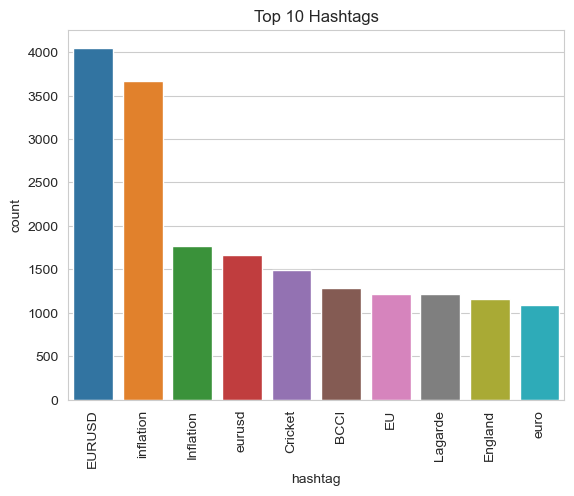

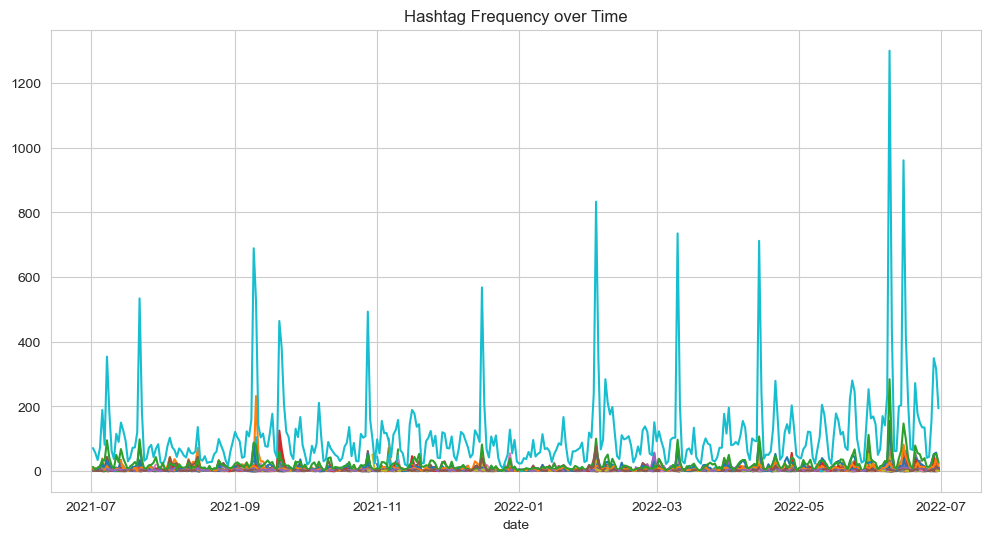

Hashtag: post
Mean Sentiment: -0.11323851674641151
Hashtag: ข่าว
Mean Sentiment: 0.0
Hashtag: Tenyearold
Mean Sentiment: 0.0
Hashtag: StockholmSyndrome
Mean Sentiment: -0.6515
Hashtag: investor
Mean Sentiment: 0.08406666666666666
Hashtag: オンラインセミナー
Mean Sentiment: 0.0
Hashtag: womensafety
Mean Sentiment: 0.0
Hashtag: testcriket
Mean Sentiment: 0.0
Hashtag: Rain
Mean Sentiment: 0.20038333333333333
Hashtag: Đức
Mean Sentiment: 0.0
Hashtag: 中銀
Mean Sentiment: 0.0
Hashtag: Tools
Mean Sentiment: -0.6597
Hashtag: eurozona
Mean Sentiment: 0.034
Hashtag: ČEZ
Mean Sentiment: 0.0
Hashtag: CoveredBondAwards2021
Mean Sentiment: 0.8751
Hashtag: maireadmcguinness
Mean Sentiment: 0.4588
Hashtag: luckyfriday
Mean Sentiment: 0.0
Hashtag: Impressing
Mean Sentiment: 0.5848
Hashtag: dividendpolicy
Mean Sentiment: 0.6369
Hashtag: BİST
Mean Sentiment: -0.016070588235294118
Hashtag: ADP
Mean Sentiment: 0.018100000000000005
Hashtag: BorisJohnsonOut11
Mean Sentiment: -0.1779
Hashtag: GFC
Mean Sentiment: -0.036

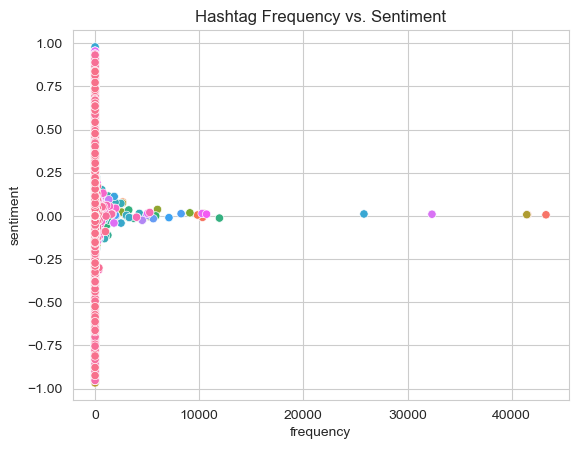

In [543]:
hashtag_evaluation("ecb")

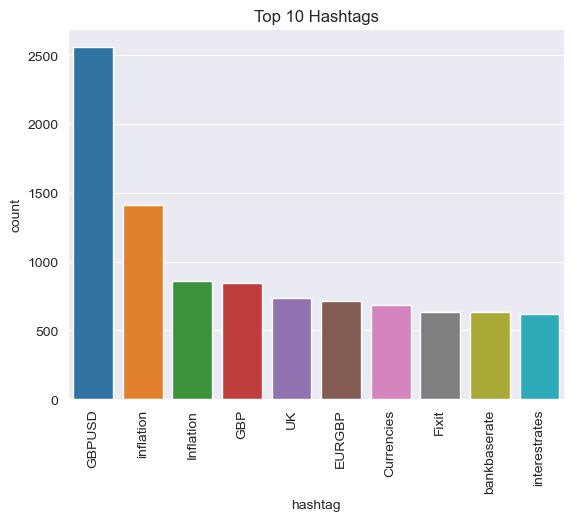

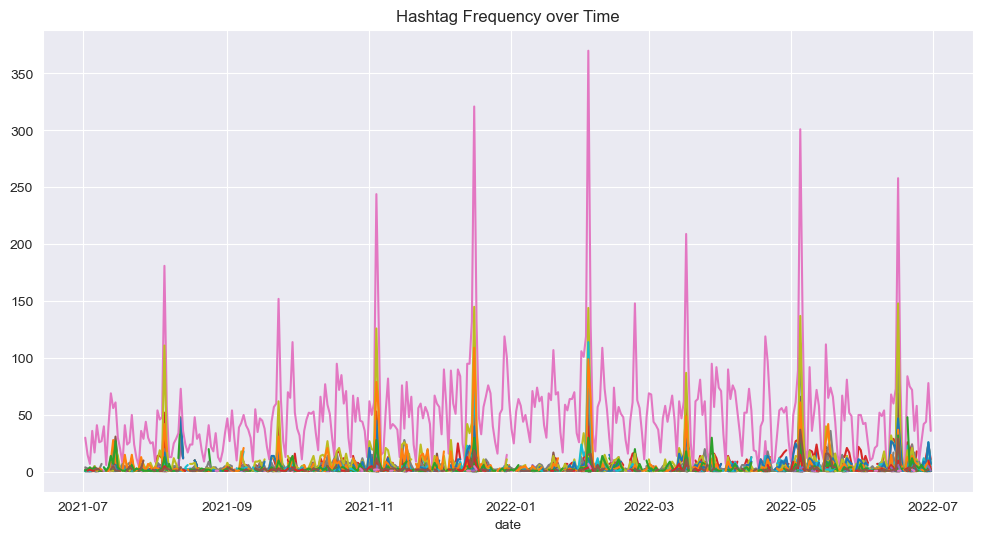

Hashtag: westtexasintermediate
Mean Sentiment: -0.5267
Hashtag: 4320p
Mean Sentiment: 0.0
Hashtag: foreignexchange
Mean Sentiment: -0.27749999999999997
Hashtag: eradigital
Mean Sentiment: 0.0
Hashtag: MREL
Mean Sentiment: -0.2023
Hashtag: RecuperaciónEconómica
Mean Sentiment: 0.0
Hashtag: Extremadura
Mean Sentiment: 0.0
Hashtag: currencymarkets
Mean Sentiment: 0.36819999999999997
Hashtag: GRIND
Mean Sentiment: 0.0
Hashtag: ConsejodeEstado
Mean Sentiment: 0.5859
Hashtag: ＦＸ初心者
Mean Sentiment: 0.0
Hashtag: EURJPY
Mean Sentiment: 0.061075000000000004
Hashtag: 利率預期
Mean Sentiment: 0.0
Hashtag: social
Mean Sentiment: -0.029428205128205126
Hashtag: derechoavoto
Mean Sentiment: 0.4019
Hashtag: oposiones
Mean Sentiment: 0.0
Hashtag: assetmanagers
Mean Sentiment: 0.10115
Hashtag: salarios
Mean Sentiment: -0.296
Hashtag: digitalnomad
Mean Sentiment: -0.296
Hashtag: Uncomplciatedadvice
Mean Sentiment: 0.2732
Hashtag: livresterling
Mean Sentiment: 0.0
Hashtag: PBC
Mean Sentiment: 0.1691
Hashtag: T

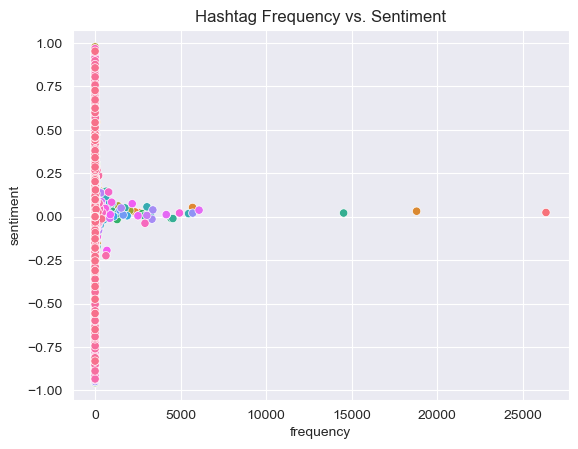

In [4]:
hashtag_evaluation("bankofengland")

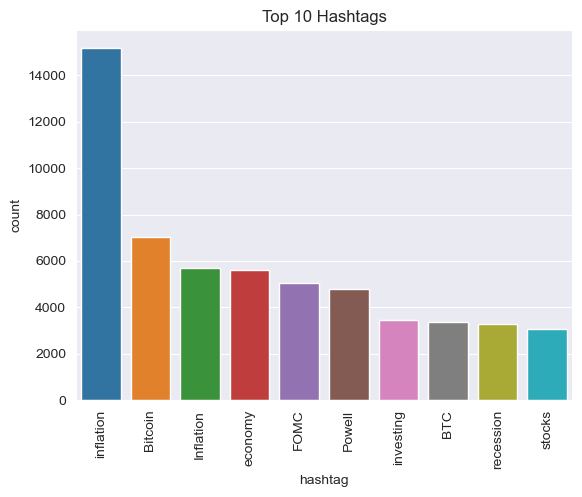

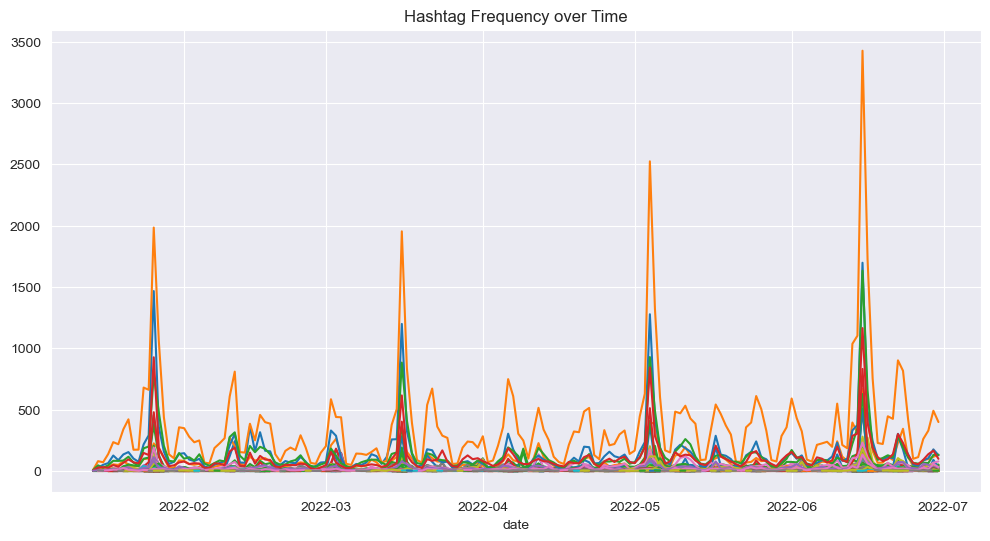

Hashtag: hossa
Mean Sentiment: 0.0
Hashtag: SuperCycle
Mean Sentiment: 0.5994
Hashtag: loyer
Mean Sentiment: -0.140525
Hashtag: Shorting
Mean Sentiment: 0.4767
Hashtag: Fedsurrection
Mean Sentiment: 0.07559999999999999
Hashtag: EURJPY
Mean Sentiment: 0.011423809523809518
Hashtag: PumpAndDump
Mean Sentiment: 0.19783333333333333
Hashtag: importante
Mean Sentiment: 0.0
Hashtag: monetarytheory
Mean Sentiment: 0.10115
Hashtag: paymentsindustry
Mean Sentiment: 0.23807192982456118
Hashtag: ตลาดหุ้นสหรัฐฯ
Mean Sentiment: 0.0
Hashtag: BrettonWoods
Mean Sentiment: -0.2652857142857143
Hashtag: LucidMotors
Mean Sentiment: 0.3612
Hashtag: financeminister
Mean Sentiment: 0.4404
Hashtag: CDNPoli
Mean Sentiment: 0.0
Hashtag: Hunt
Mean Sentiment: -0.058966666666666674
Hashtag: parries
Mean Sentiment: 0.34
Hashtag: realestateinvestor
Mean Sentiment: -0.3182
Hashtag: silver
Mean Sentiment: 0.052038364779874224
Hashtag: WeimarAmericaBabweUela
Mean Sentiment: -0.0129
Hashtag: pure
Mean Sentiment: -0.3592
H

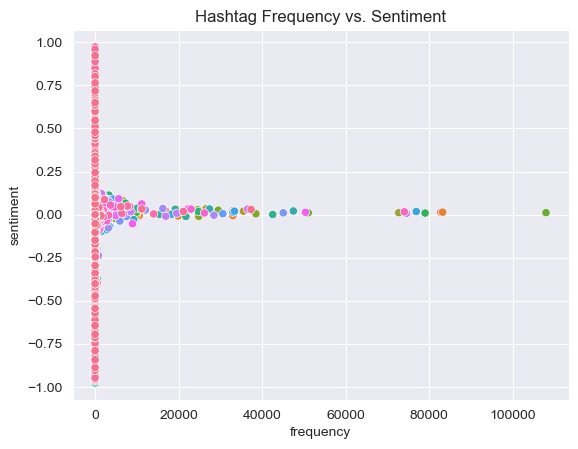

In [7]:
hashtag_evaluation("federalreserve")

***
**Case Study: Whatever it takes**


15 Days Pre-Speech

In [12]:
get_tweets_csv("","2012-07-20",9,5,2)

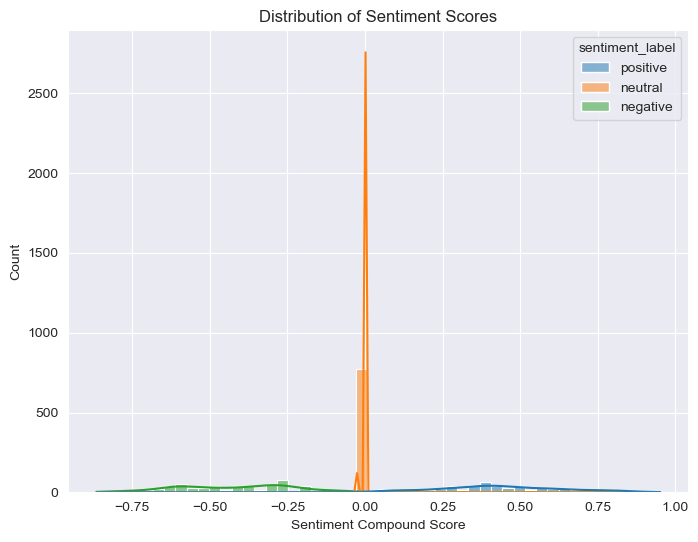

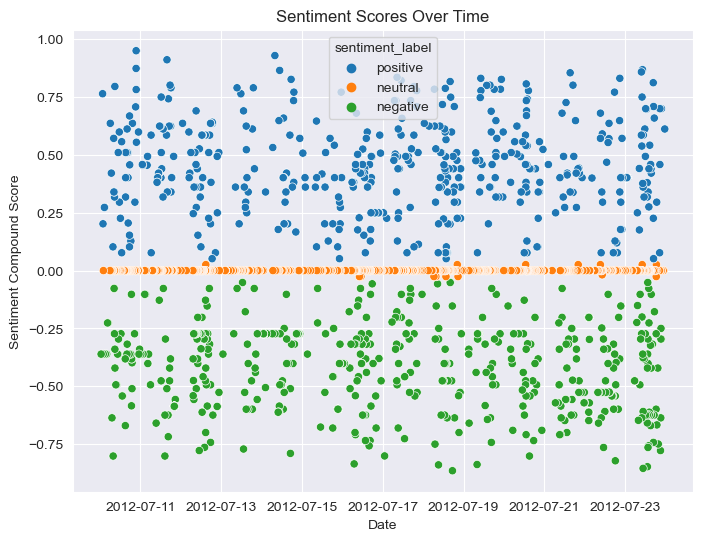

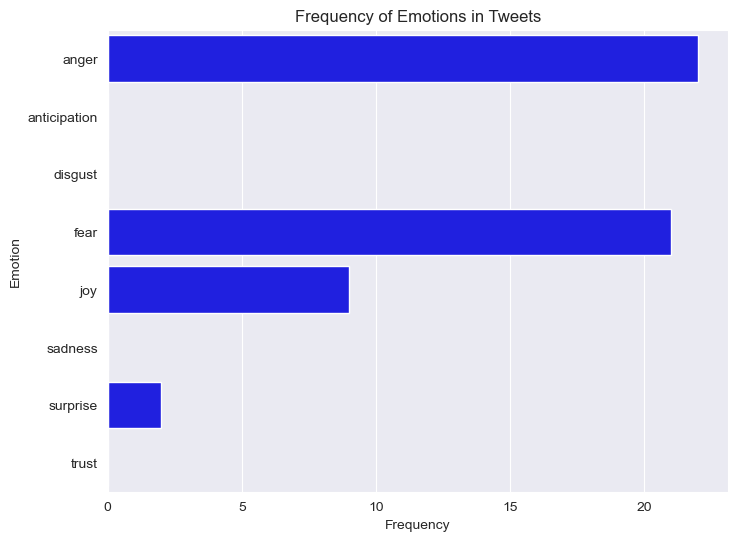

In [16]:
sentiment_analysis("15_days_before", 0)

15 Days After-Speech

In [ ]:
get_tweets_csv("","2012-07-30",4,10,3)

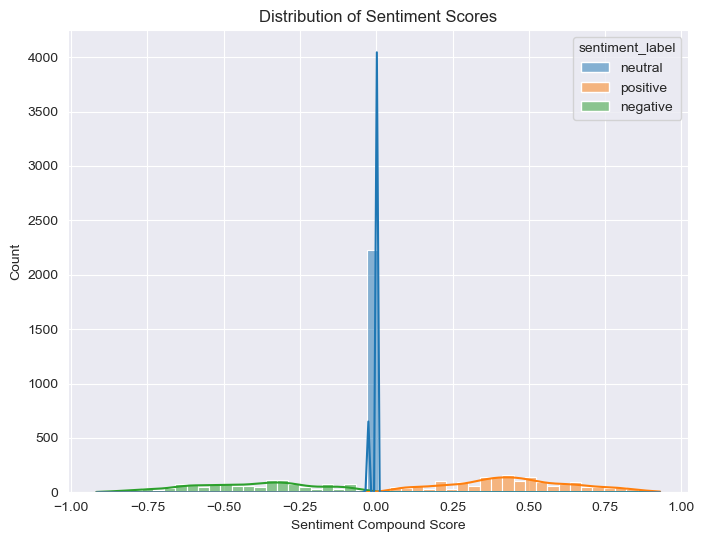

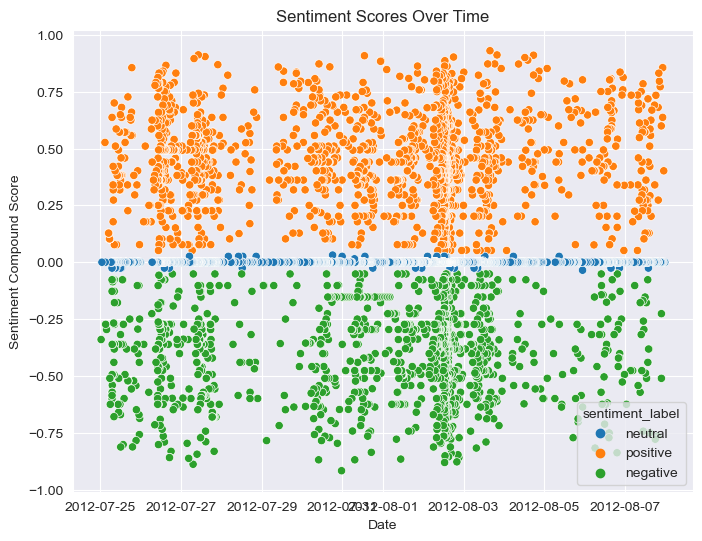

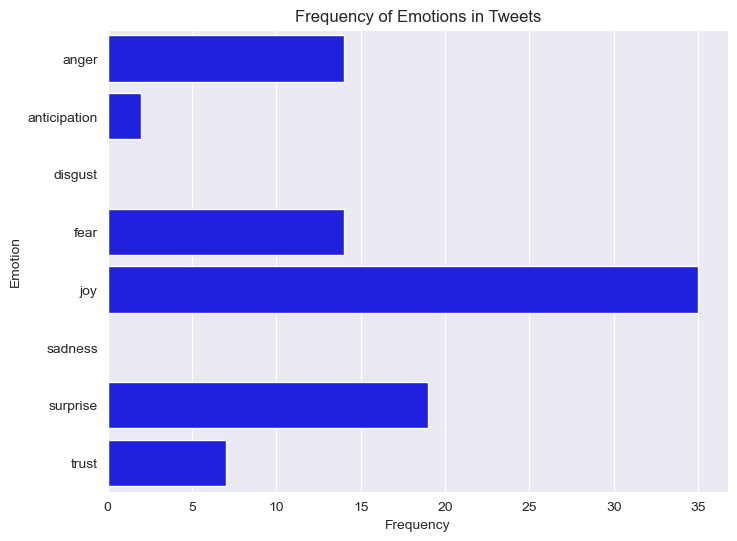

In [17]:
sentiment_analysis("15_days_after", 0)

Main tweet

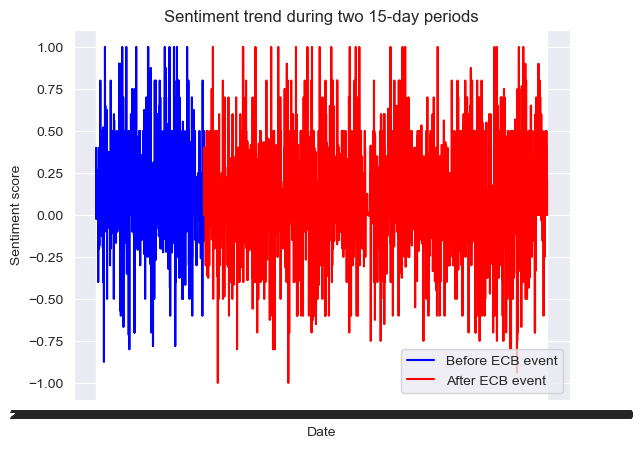

In [33]:

# Load the two CSV files into Pandas DataFrames
df_before = pd.read_csv('15_days_before_tweets.csv')
df_after = pd.read_csv('15_days_after_tweets.csv')

# Extract the tweet text and tweet date columns
df_before = df_before[['tweet_text', 'tweet_date']]
df_after = df_after[['tweet_text', 'tweet_date']]

# Perform sentiment analysis on the tweet text using TextBlob
df_before['sentiment'] = df_before['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_after['sentiment'] = df_after['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Merge the two DataFrames and add a column indicating whether the tweet is from before or after the ECB event
df_before['period'] = 'before'
df_after['period'] = 'after'
df_merged = pd.concat([df_before, df_after])

# Group the merged DataFrame by date and calculate the mean sentiment score for each date
df_grouped = df_merged.groupby('tweet_date').mean().reset_index()

# Plot the mean sentiment scores against the date, using different colors for the two periods
fig, ax = plt.subplots()
before = df_grouped[df_grouped['tweet_date'].between('2012-07-10', '2012-07-23')]
after = df_grouped[df_grouped['tweet_date'].between('2012-07-25', '2012-08-07')]
ax.plot(before['tweet_date'], before['sentiment'], color='blue', label='Before ECB event')
ax.plot(after['tweet_date'], after['sentiment'], color='red', label='After ECB event')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment trend during two 15-day periods')
ax.legend()
plt.show()


Correlation with stock Market

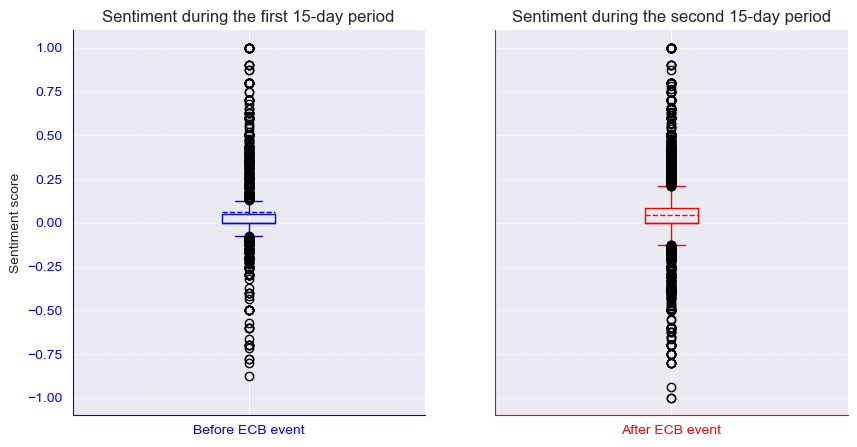

In [35]:

df_before = pd.read_csv('15_days_before_tweets.csv')
df_after = pd.read_csv('15_days_after_tweets.csv')

df_before = df_before[['tweet_text', 'tweet_date']]
df_after = df_after[['tweet_text', 'tweet_date']]

# Perform sentiment analysis on the tweet text using TextBlob
df_before['sentiment'] = df_before['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_after['sentiment'] = df_after['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a figure with two subplots, one for each 15-day period
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Create a boxplot for the first 15-day period
df_before_box = df_before[df_before['tweet_date'].between('2012-07-10', '2012-07-23')]
axs[0].boxplot(df_before_box['sentiment'], labels=['Before ECB event'], showmeans=True, meanline=True)
axs[0].set_title('Sentiment during the first 15-day period')
axs[0].set_ylabel('Sentiment score')

# Create a boxplot for the second 15-day period
df_after_box = df_after[df_after['tweet_date'].between('2012-07-25', '2012-08-07')]
axs[1].boxplot(df_after_box['sentiment'], labels=['After ECB event'], showmeans=True, meanline=True)
axs[1].set_title('Sentiment during the second 15-day period')

# Set the colors of the boxplots
colors = ['blue', 'red']
for i in range(len(axs)):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_color(colors[i])
    axs[i].spines['left'].set_color(colors[i])
    axs[i].tick_params(axis='x', colors=colors[i])
    axs[i].tick_params(axis='y', colors=colors[i])
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    for j in range(len(axs[i].lines)):
        axs[i].lines[j].set_color(colors[i])

plt.show()


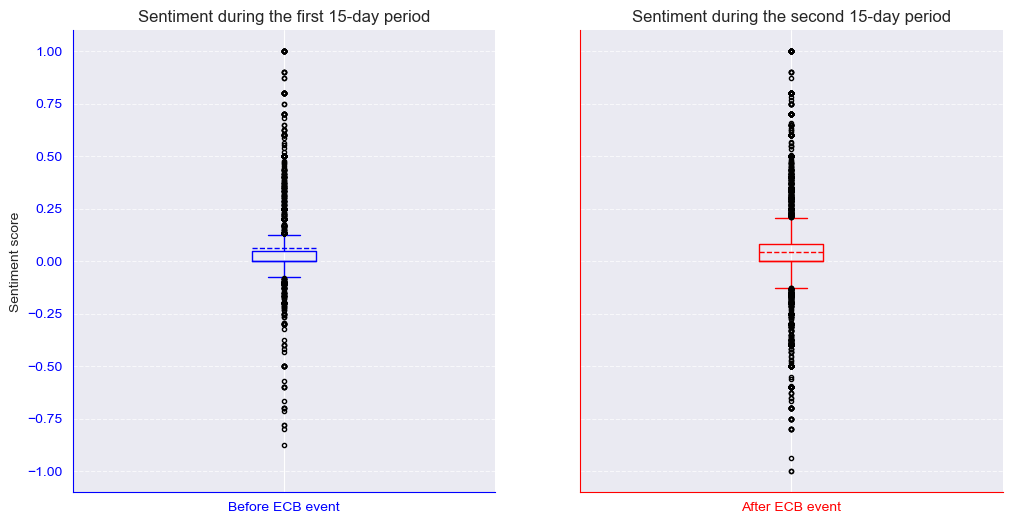

In [39]:

df_before = pd.read_csv('15_days_before_tweets.csv')
df_after = pd.read_csv('15_days_after_tweets.csv')

df_before = df_before[['tweet_text', 'tweet_date']]
df_after = df_after[['tweet_text', 'tweet_date']]

# Perform sentiment analysis on the tweet text using TextBlob
df_before['sentiment'] = df_before['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_after['sentiment'] = df_after['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

df_before_box = df_before[df_before['tweet_date'].between('2012-07-10', '2012-07-23')]
axs[0].boxplot(df_before_box['sentiment'], labels=['Before ECB event'], showmeans=True, meanline=True, sym='.')
axs[0].set_title('Sentiment during the first 15-day period')
axs[0].set_ylabel('Sentiment score')

df_after_box = df_after[df_after['tweet_date'].between('2012-07-25', '2012-08-07')]
axs[1].boxplot(df_after_box['sentiment'], labels=['After ECB event'], showmeans=True, meanline=True, sym='.')
axs[1].set_title('Sentiment during the second 15-day period')

# Set the colors of the boxplots
colors = ['blue', 'red']
for i in range(len(axs)):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_color(colors[i])
    axs[i].spines['left'].set_color(colors[i])
    axs[i].tick_params(axis='x', colors=colors[i])
    axs[i].tick_params(axis='y', colors=colors[i])
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    for j in range(len(axs[i].lines)):
        axs[i].lines[j].set_color(colors[i])

plt.subplots_adjust(wspace=0.2)

plt.show()
